In [1]:
import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader

import models.loadImg as loadImg
import models.modelsCNN as modelsCNN
import models.optimizer as optimizer

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc
from skimage import io
import scipy.stats

In [2]:
# os.environ["CUDA_LAUNCH_BLOCKING"] = "3" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0,1,2,3'
use_cuda=True
datadir='/media/xinyi/dcis2idc/data'
name='exp0'
plotsavepath='/media/xinyi/dcis2idc/plots/cnnvae'+name
sampledir=plotsavepath
clustersavedir_alltrain=os.path.join(sampledir,'cluster_alltrain_reordered')

In [3]:
with open(os.path.join(datadir,'processed','train_cnnvae_names'), 'rb') as input:
    allImgNames=pickle.load(input)

br1003aSpecs=pd.read_excel('/media/xinyi/dcis2idc/data/BR1003a specs.xlsx',header=10)
br301Specs=pd.read_excel('/media/xinyi/dcis2idc/data/BR301 specs.xlsx',header=10)
br8018aSpecs=pd.read_excel('/media/xinyi/dcis2idc/data/BR8018a specs.xlsx',header=10)
br1003aSpecs.index=br1003aSpecs.loc[:,'Position']
br301Specs.index=br301Specs.loc[:,'Position']
br8018aSpecs.index=br8018aSpecs.loc[:,'Position']
progList=np.copy(allImgNames)
for s in np.unique(allImgNames):
    ssplit=s.split('_')
    if 'br1003a'==ssplit[0]:
        prog_s=br1003aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br301'==ssplit[0]:
        prog_s=br301Specs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br8018a'==ssplit[0]:
        prog_s=br8018aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    progList[allImgNames==s]=prog_s

In [4]:
plotepoch=311
np.random.seed(6)
# plotPCT=4500
n_pcs=50
    
ncluster=8
plotsavenameAdd='_plottingIdx_progBalanced_'+str(0)
savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+plotsavenameAdd
with open(os.path.join(clustersavedir_alltrain,'minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_all'), 'rb') as output:
    clusterRes=pickle.load(output)

In [5]:
savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+plotsavenameAdd
neworder=[1, 5, 3, 7, 2, 0, 4, 6]
subclusternumbers=[4,6,8,6,6,6,6,4]
clusterRes_sub=np.zeros(clusterRes.size)-1
for cnew in np.unique(clusterRes):
    c=neworder[cnew]
    subclustersavedir_alltrain=os.path.join(clustersavedir_alltrain,savenamecluster+'_subcluster'+str(c))
    subclusterplotdir_alltrain=os.path.join(subclustersavedir_alltrain,'plots')
    with open(os.path.join(subclustersavedir_alltrain,'minibatchkmean_ncluster'+str(subclusternumbers[c])+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_all'), 'rb') as output:
        clusterRes_sub[clusterRes==cnew]=pickle.load(output)

In [6]:
with open(os.path.join(datadir,'processed','train_cnnvae_cellLabels'), 'rb') as output:
    cellIDlist=pickle.load(output)

In [7]:
with open(os.path.join(datadir,'processed','latent311'), 'rb') as input:
    latent=pickle.load(input)

In [8]:
plottingIdx_i=np.arange(latent.shape[0])

In [9]:
with open(os.path.join(datadir,'processed','train_cnnvae_coord'), 'rb') as output:
    coordlist=pickle.load(output)

In [51]:
origImg=io.imread(os.path.join(datadir,'_'.join(s.split('_')[:-1]),'zproject','dna',s.split('_')[-1] +'.tif'))

In [59]:
origImg=(origImg-np.min(origImg))/(np.max(origImg)-np.min(origImg))

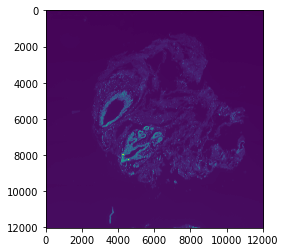

In [60]:
plt.imshow(origImg)

In [61]:
origImg.shape

(12024, 12024)

In [72]:
ductSeg_bin=np.zeros_like(ductSeg)
ductSeg_bin[ductSeg>0]=1

In [90]:
comp=np.zeros((ductSeg_bin.shape[0],ductSeg_bin.shape[1],3))
comp[:,:,0]=ductSeg_bin
comp[:,:,2]=origImg[1482:-922,1802:-602]
plt.imsave(os.path.join(datadir,'duct_manual','labeled_images','_'.join(s.split('_')[:-1]),s.split('_')[-1] +'_testoverlay.jpg'),comp)

In [93]:
#load duct membership
uniquenames,nameIdx=np.unique(allImgNames,return_index=True)

allstats=None
alllabels=None
alllabels_sub=None
alllatents=None
for sidx in range(uniquenames.size):
    s=np.unique(allImgNames)[sidx]

    path_s=os.path.join(datadir,'duct_manual','labeled_images','_'.join(s.split('_')[:-1]),s.split('_')[-1] +'.tif')
    if not os.path.exists(path_s):
        continue
    print(s)
    plottingIdx_i_s=plottingIdx_i[allImgNames==s]-nameIdx[sidx]
    assert np.min(plottingIdx_i_s)>=0
    
    ductSeg=io.imread(path_s)
    stats_s=np.zeros(np.sum(allImgNames==s))
    if s =='br1003a_1_cytokeratin_555_aSMA_647_hoechst_A2':
        temp=np.zeros((12024,12024))
        temp[1482:-922,1802:-602]=ductSeg
        ductSeg=temp
    for cell_i in range(np.sum(allImgNames==s)):
        coord_i=coordlist[allImgNames==s][cell_i].astype(int)
        if ductSeg[coord_i[0],coord_i[1]]>0:
            stats_s[cell_i]=1
    

#         ssplit=s.split('_')
    slabels=clusterRes[allImgNames==s]
    slabels_sub=clusterRes_sub[allImgNames==s]
    
    latent_s=latent[allImgNames==s]

    if allstats is None:
        allstats=stats_s
        alllabels=np.copy(slabels)
        alllabels_sub=np.copy(slabels_sub)
        alllatents=latent_s
    else:
        allstats=np.concatenate((allstats,stats_s))
        alllabels=np.concatenate((alllabels,np.copy(slabels)))
        alllabels_sub=np.concatenate((alllabels_sub,np.copy(slabels_sub)))
        alllatents=np.concatenate((alllatents,latent_s),axis=0)


br1003a_1_cytokeratin_555_aSMA_647_hoechst_A2
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I10
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I3
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I8
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I9
br301_4_cytokeratin_555_aSMA_647_hoechst_A3
br301_4_cytokeratin_555_aSMA_647_hoechst_B3
br301_4_cytokeratin_555_aSMA_647_hoechst_C4
br301_4_cytokeratin_555_aSMA_647_hoechst_D3
br301_4_cytokeratin_555_aSMA_647_hoechst_D4
br301_4_cytokeratin_555_aSMA_647_hoechst_D5
br301_4_cytokeratin_555_aSMA_647_hoechst_D6
br301_4_cytokeratin_555_aSMA_647_hoechst_E3
br301_4_cytokeratin_555_aSMA_647_hoechst_E4
br301_4_cytokeratin_555_aSMA_647_hoechst_E5
br301_4_cytokeratin_555_aSMA_647_hoechst_E6


In [99]:
with open(os.path.join(datadir,'duct_manual','cellmembership'), 'wb') as output:
    pickle.dump(allstats, output, pickle.HIGHEST_PROTOCOL)

In [94]:
seed=3
epochs=6000
saveFreq=200
lr=0.001 #initial learning rate
weight_decay=0 #Weight for L2 loss on embedding matrix.

minCells=50

# batchsize=4
batchsize=6000
model_str='fc3'

kernel_size=4
stride=2
padding=1

fc_dim1=1024
fc_dim2=1024
fc_dim3=1024


dropout=0.01
kl_weight=0.0000001

name='exp0_ductClf_latent_subclusters_'+savenamecluster+'fcl3'+'_manual'
logsavepath='/media/xinyi/dcis2idc/log/cnnvae'+name
modelsavepath='/media/xinyi/dcis2idc/models/cnnvae'+name
plotsavepath='/media/xinyi/dcis2idc/plots/cnnvae'+name


if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)


In [95]:
def train(epoch):
    t = time.time()
    model.train()
    
    loss_all=0
    for i in range(int(np.ceil(trainIdx.shape[0]/batchsize))):
        trainIdx_i=trainIdx[i*batchsize:min((i+1)*batchsize,trainIdx.shape[0])]
        
#         trainInput=trainInputnp[trainIdx]
#         labels=trainLabelsnp[trainIdx]
        if use_cuda:
            trainInput=torch.tensor(stats_sub[trainIdx_i]).cuda().float()
            labels=torch.tensor(labels_sub[trainIdx_i]).cuda().float()
        optimizer.zero_grad()

        pred = model(trainInput)
#         print(trainInput)
#         print(pred)


        loss=lossCE(pred.flatten(),labels)
        loss_all+=loss.item()
        
        loss.backward()
        optimizer.step()

    loss_all=loss_all/int(np.ceil(trainIdx.shape[0]/batchsize))
    
    with torch.no_grad():
        model.eval()
        loss_val_all=0
        nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
            if use_cuda:
                valInput=torch.tensor(stats_sub[valIdx_i]).cuda().float()
                labels=torch.tensor(labels_sub[valIdx_i]).cuda().float()
                
            pred= model(valInput)

            loss_val=lossCE(pred.flatten(),labels).item()

            loss_val_all+=loss_val

        loss_val_all=loss_val_all/nvalBatches
    if epoch%50==0:
        print('Epoch: {:04d}'.format(epoch),
              'loss_train: {:.4f}'.format(loss_all),
              'loss_val: {:.4f}'.format(loss_val_all))
    return loss_all,loss_val_all

Epoch: 0000 loss_train: 1.2664 loss_val: 1.2447
Epoch: 0050 loss_train: 1.1666 loss_val: 1.1471
Epoch: 0100 loss_train: 1.0923 loss_val: 1.1717
Epoch: 0150 loss_train: 1.0387 loss_val: 1.1567
Epoch: 0200 loss_train: 0.9669 loss_val: 1.2795
Epoch: 0250 loss_train: 0.9638 loss_val: 1.2076
Epoch: 0300 loss_train: 0.8898 loss_val: 1.3033
Epoch: 0350 loss_train: 0.8579 loss_val: 1.5764
Epoch: 0400 loss_train: 0.8261 loss_val: 1.5745
Epoch: 0450 loss_train: 0.7549 loss_val: 1.8016
Epoch: 0500 loss_train: 0.7436 loss_val: 1.8766
Epoch: 0550 loss_train: 0.8031 loss_val: 1.9989
Epoch: 0600 loss_train: 0.7302 loss_val: 1.9499
Epoch: 0650 loss_train: 0.7312 loss_val: 2.0118
Epoch: 0700 loss_train: 0.7076 loss_val: 2.3874
Epoch: 0750 loss_train: 0.6844 loss_val: 2.2607
Epoch: 0800 loss_train: 0.6969 loss_val: 2.1599
Epoch: 0850 loss_train: 0.6735 loss_val: 2.3593
Epoch: 0900 loss_train: 0.6417 loss_val: 2.6028
Epoch: 0950 loss_train: 0.6532 loss_val: 2.5920
Epoch: 1000 loss_train: 0.6208 loss_val:

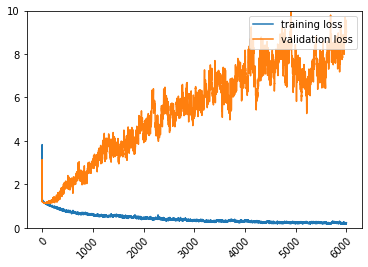

Epoch: 0000 loss_train: 1.2432 loss_val: 1.3440
Epoch: 0050 loss_train: 1.1969 loss_val: 1.3142
Epoch: 0100 loss_train: 1.1304 loss_val: 1.3570
Epoch: 0150 loss_train: 1.0759 loss_val: 1.3793
Epoch: 0200 loss_train: 1.0572 loss_val: 1.3390
Epoch: 0250 loss_train: 1.0170 loss_val: 1.4008
Epoch: 0300 loss_train: 1.0340 loss_val: 1.4046
Epoch: 0350 loss_train: 0.9987 loss_val: 1.4393
Epoch: 0400 loss_train: 0.9835 loss_val: 1.5179
Epoch: 0450 loss_train: 0.9680 loss_val: 1.4742
Epoch: 0500 loss_train: 0.9906 loss_val: 1.4080
Epoch: 0550 loss_train: 0.9683 loss_val: 1.3503
Epoch: 0600 loss_train: 0.9719 loss_val: 1.4154
Epoch: 0650 loss_train: 0.9488 loss_val: 1.4462
Epoch: 0700 loss_train: 0.9733 loss_val: 1.4276
Epoch: 0750 loss_train: 0.9808 loss_val: 1.5167
Epoch: 0800 loss_train: 0.9644 loss_val: 1.8685
Epoch: 0850 loss_train: 0.9443 loss_val: 1.4871
Epoch: 0900 loss_train: 0.9587 loss_val: 1.4193
Epoch: 0950 loss_train: 0.9991 loss_val: 1.5567
Epoch: 1000 loss_train: 0.9087 loss_val:

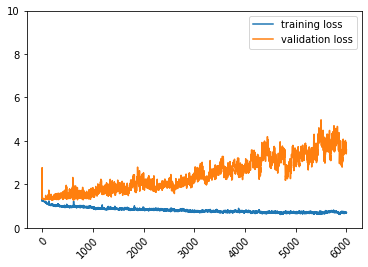

Epoch: 0000 loss_train: 1.2835 loss_val: 2.5079
Epoch: 0050 loss_train: 1.0185 loss_val: 1.1137
Epoch: 0100 loss_train: 0.9549 loss_val: 1.1121
Epoch: 0150 loss_train: 0.9146 loss_val: 1.1577
Epoch: 0200 loss_train: 0.9187 loss_val: 1.1425
Epoch: 0250 loss_train: 0.8790 loss_val: 1.1717
Epoch: 0300 loss_train: 0.8540 loss_val: 1.1588
Epoch: 0350 loss_train: 0.8595 loss_val: 1.2010
Epoch: 0400 loss_train: 0.8254 loss_val: 1.2068
Epoch: 0450 loss_train: 0.8204 loss_val: 1.2483
Epoch: 0500 loss_train: 0.8446 loss_val: 1.2463
Epoch: 0550 loss_train: 0.7445 loss_val: 1.2375
Epoch: 0600 loss_train: 0.7381 loss_val: 1.3655
Epoch: 0650 loss_train: 0.6967 loss_val: 1.2970
Epoch: 0700 loss_train: 0.6409 loss_val: 1.4172
Epoch: 0750 loss_train: 0.6768 loss_val: 1.3886
Epoch: 0800 loss_train: 0.6615 loss_val: 1.3310
Epoch: 0850 loss_train: 0.7034 loss_val: 1.3582
Epoch: 0900 loss_train: 0.7030 loss_val: 1.3280
Epoch: 0950 loss_train: 0.6687 loss_val: 1.4380
Epoch: 1000 loss_train: 0.6572 loss_val:

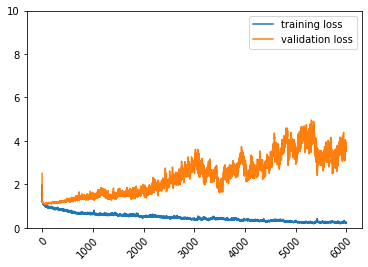

Epoch: 0000 loss_train: 1.2717 loss_val: 1.2561
Epoch: 0050 loss_train: 1.2252 loss_val: 1.1700
Epoch: 0100 loss_train: 1.1373 loss_val: 1.2614
Epoch: 0150 loss_train: 1.1052 loss_val: 1.3283
Epoch: 0200 loss_train: 1.0865 loss_val: 1.7041
Epoch: 0250 loss_train: 0.9831 loss_val: 1.9089
Epoch: 0300 loss_train: 0.9530 loss_val: 2.4188
Epoch: 0350 loss_train: 0.9547 loss_val: 2.6804
Epoch: 0400 loss_train: 0.9275 loss_val: 2.3884
Epoch: 0450 loss_train: 0.8146 loss_val: 4.1593
Epoch: 0500 loss_train: 0.8318 loss_val: 3.6240
Epoch: 0550 loss_train: 0.7843 loss_val: 5.2173
Epoch: 0600 loss_train: 0.7897 loss_val: 4.6031
Epoch: 0650 loss_train: 0.7557 loss_val: 5.6458
Epoch: 0700 loss_train: 0.7435 loss_val: 6.2668
Epoch: 0750 loss_train: 0.6936 loss_val: 6.3714
Epoch: 0800 loss_train: 0.7757 loss_val: 6.6859
Epoch: 0850 loss_train: 0.7634 loss_val: 6.2459
Epoch: 0900 loss_train: 0.7144 loss_val: 8.0453
Epoch: 0950 loss_train: 0.6872 loss_val: 4.7039
Epoch: 1000 loss_train: 0.7275 loss_val:

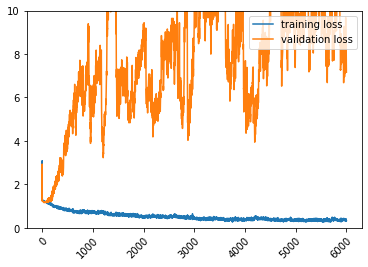

Epoch: 0000 loss_train: 1.2733 loss_val: 1.2317
Epoch: 0050 loss_train: 1.0677 loss_val: 1.0857
Epoch: 0100 loss_train: 0.9600 loss_val: 1.0868
Epoch: 0150 loss_train: 0.8938 loss_val: 1.1615
Epoch: 0200 loss_train: 0.8019 loss_val: 1.5492
Epoch: 0250 loss_train: 0.8052 loss_val: 1.7135
Epoch: 0300 loss_train: 0.7140 loss_val: 2.4513
Epoch: 0350 loss_train: 0.7372 loss_val: 2.3132
Epoch: 0400 loss_train: 0.6772 loss_val: 2.8932
Epoch: 0450 loss_train: 0.6551 loss_val: 2.4084
Epoch: 0500 loss_train: 0.6220 loss_val: 3.3485
Epoch: 0550 loss_train: 0.6276 loss_val: 2.6346
Epoch: 0600 loss_train: 0.6122 loss_val: 2.5844
Epoch: 0650 loss_train: 0.5789 loss_val: 3.2920
Epoch: 0700 loss_train: 0.5082 loss_val: 3.0759
Epoch: 0750 loss_train: 0.4935 loss_val: 3.6945
Epoch: 0800 loss_train: 0.5129 loss_val: 2.6772
Epoch: 0850 loss_train: 0.4425 loss_val: 3.8956
Epoch: 0900 loss_train: 0.4520 loss_val: 4.3100
Epoch: 0950 loss_train: 0.4614 loss_val: 4.2892
Epoch: 1000 loss_train: 0.4592 loss_val:

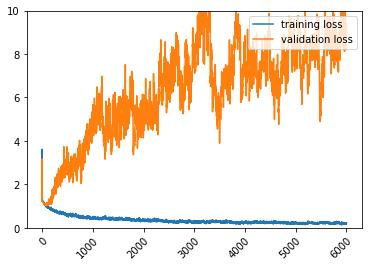

Epoch: 0000 loss_train: 1.2611 loss_val: 1.2373
Epoch: 0050 loss_train: 1.1157 loss_val: 1.1112
Epoch: 0100 loss_train: 1.0305 loss_val: 1.1002
Epoch: 0150 loss_train: 0.9325 loss_val: 1.1164
Epoch: 0200 loss_train: 0.8466 loss_val: 1.1401
Epoch: 0250 loss_train: 0.8452 loss_val: 1.2104
Epoch: 0300 loss_train: 0.8129 loss_val: 1.4464
Epoch: 0350 loss_train: 0.7832 loss_val: 1.3809
Epoch: 0400 loss_train: 0.7713 loss_val: 1.2885
Epoch: 0450 loss_train: 0.7023 loss_val: 1.4599
Epoch: 0500 loss_train: 0.7126 loss_val: 1.3838
Epoch: 0550 loss_train: 0.7567 loss_val: 1.2737
Epoch: 0600 loss_train: 0.6547 loss_val: 1.7070
Epoch: 0650 loss_train: 0.6351 loss_val: 1.7824
Epoch: 0700 loss_train: 0.6504 loss_val: 1.9316
Epoch: 0750 loss_train: 0.5527 loss_val: 2.5965
Epoch: 0800 loss_train: 0.5648 loss_val: 2.4185
Epoch: 0850 loss_train: 0.5655 loss_val: 2.1810
Epoch: 0900 loss_train: 0.5708 loss_val: 2.1310
Epoch: 0950 loss_train: 0.5709 loss_val: 2.6247
Epoch: 1000 loss_train: 0.5395 loss_val:

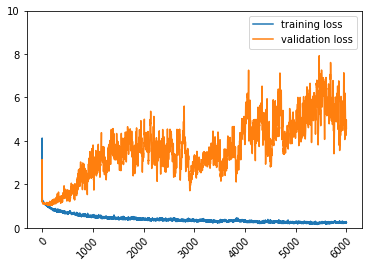

Epoch: 0000 loss_train: 1.2602 loss_val: 1.2384
Epoch: 0050 loss_train: 1.0576 loss_val: 1.0192
Epoch: 0100 loss_train: 0.9536 loss_val: 1.2702
Epoch: 0150 loss_train: 0.8220 loss_val: 1.3356
Epoch: 0200 loss_train: 0.7832 loss_val: 1.3795
Epoch: 0250 loss_train: 0.6586 loss_val: 1.6176
Epoch: 0300 loss_train: 0.6557 loss_val: 1.6663
Epoch: 0350 loss_train: 0.7199 loss_val: 1.7553
Epoch: 0400 loss_train: 0.6031 loss_val: 1.8325
Epoch: 0450 loss_train: 0.5725 loss_val: 2.2350
Epoch: 0500 loss_train: 0.5309 loss_val: 2.3770
Epoch: 0550 loss_train: 0.5657 loss_val: 2.4155
Epoch: 0600 loss_train: 0.5484 loss_val: 2.3440
Epoch: 0650 loss_train: 0.5350 loss_val: 2.4019
Epoch: 0700 loss_train: 0.4735 loss_val: 2.9317
Epoch: 0750 loss_train: 0.4391 loss_val: 3.0887
Epoch: 0800 loss_train: 0.4272 loss_val: 3.1539
Epoch: 0850 loss_train: 0.4227 loss_val: 3.3487
Epoch: 0900 loss_train: 0.4469 loss_val: 3.0952
Epoch: 0950 loss_train: 0.3622 loss_val: 3.8370
Epoch: 1000 loss_train: 0.4085 loss_val:

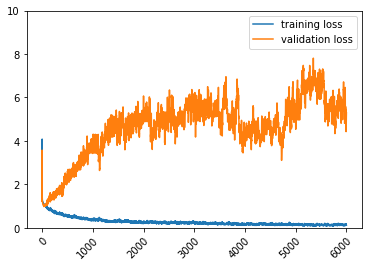

Epoch: 0000 loss_train: 1.1970 loss_val: 1.3414
Epoch: 0050 loss_train: 0.9823 loss_val: 1.3814
Epoch: 0100 loss_train: 0.8695 loss_val: 1.4543
Epoch: 0150 loss_train: 0.7967 loss_val: 1.6277
Epoch: 0200 loss_train: 0.7609 loss_val: 1.9666
Epoch: 0250 loss_train: 0.6704 loss_val: 1.9766
Epoch: 0300 loss_train: 0.6400 loss_val: 2.4909
Epoch: 0350 loss_train: 0.6527 loss_val: 2.3305
Epoch: 0400 loss_train: 0.5546 loss_val: 2.9172
Epoch: 0450 loss_train: 0.4905 loss_val: 3.1194
Epoch: 0500 loss_train: 0.5247 loss_val: 3.0280
Epoch: 0550 loss_train: 0.4731 loss_val: 3.6266
Epoch: 0600 loss_train: 0.4678 loss_val: 3.6917
Epoch: 0650 loss_train: 0.4633 loss_val: 3.5029
Epoch: 0700 loss_train: 0.3933 loss_val: 3.3237
Epoch: 0750 loss_train: 0.5095 loss_val: 2.7955
Epoch: 0800 loss_train: 0.4505 loss_val: 3.9216
Epoch: 0850 loss_train: 0.4139 loss_val: 4.3049
Epoch: 0900 loss_train: 0.4031 loss_val: 4.7144
Epoch: 0950 loss_train: 0.3952 loss_val: 4.1496
Epoch: 1000 loss_train: 0.3614 loss_val:

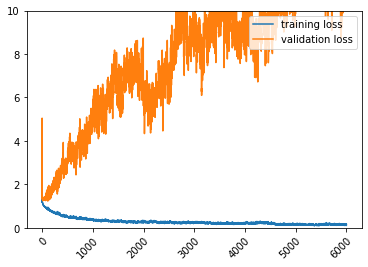

Epoch: 0000 loss_train: 1.2546 loss_val: 1.4116
Epoch: 0050 loss_train: 1.0866 loss_val: 1.3155
Epoch: 0100 loss_train: 0.9936 loss_val: 1.6381
Epoch: 0150 loss_train: 0.9201 loss_val: 1.7659
Epoch: 0200 loss_train: 0.9348 loss_val: 1.7281
Epoch: 0250 loss_train: 0.8752 loss_val: 1.8756
Epoch: 0300 loss_train: 0.8021 loss_val: 1.6740
Epoch: 0350 loss_train: 0.7636 loss_val: 2.1432
Epoch: 0400 loss_train: 0.7594 loss_val: 2.6396
Epoch: 0450 loss_train: 0.7063 loss_val: 2.7314
Epoch: 0500 loss_train: 0.6989 loss_val: 2.9592
Epoch: 0550 loss_train: 0.7377 loss_val: 1.9683
Epoch: 0600 loss_train: 0.6695 loss_val: 2.5202
Epoch: 0650 loss_train: 0.6024 loss_val: 3.1353
Epoch: 0700 loss_train: 0.5783 loss_val: 4.1294
Epoch: 0750 loss_train: 0.5722 loss_val: 3.6166
Epoch: 0800 loss_train: 0.6130 loss_val: 3.4209
Epoch: 0850 loss_train: 0.5414 loss_val: 3.4077
Epoch: 0900 loss_train: 0.5256 loss_val: 4.3987
Epoch: 0950 loss_train: 0.5508 loss_val: 4.4451
Epoch: 1000 loss_train: 0.5288 loss_val:

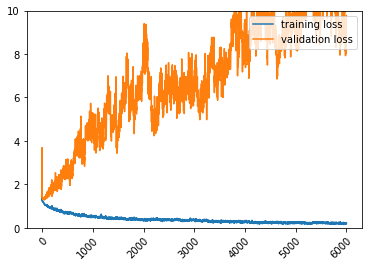

Epoch: 0000 loss_train: 1.2298 loss_val: 1.3283
Epoch: 0050 loss_train: 1.0632 loss_val: 1.1003
Epoch: 0100 loss_train: 0.9810 loss_val: 1.1382
Epoch: 0150 loss_train: 0.9143 loss_val: 1.2720
Epoch: 0200 loss_train: 0.8618 loss_val: 1.5853
Epoch: 0250 loss_train: 0.8046 loss_val: 1.6226
Epoch: 0300 loss_train: 0.7764 loss_val: 1.7176
Epoch: 0350 loss_train: 0.6839 loss_val: 2.2968
Epoch: 0400 loss_train: 0.6816 loss_val: 2.2699
Epoch: 0450 loss_train: 0.6381 loss_val: 2.5552
Epoch: 0500 loss_train: 0.6273 loss_val: 2.5788
Epoch: 0550 loss_train: 0.6152 loss_val: 2.9084
Epoch: 0600 loss_train: 0.5865 loss_val: 3.3795
Epoch: 0650 loss_train: 0.5527 loss_val: 3.8733
Epoch: 0700 loss_train: 0.5511 loss_val: 3.6120
Epoch: 0750 loss_train: 0.5275 loss_val: 4.1478
Epoch: 0800 loss_train: 0.5137 loss_val: 4.2493
Epoch: 0850 loss_train: 0.4814 loss_val: 3.9604
Epoch: 0900 loss_train: 0.4816 loss_val: 4.3178
Epoch: 0950 loss_train: 0.4425 loss_val: 4.6176
Epoch: 1000 loss_train: 0.4434 loss_val:

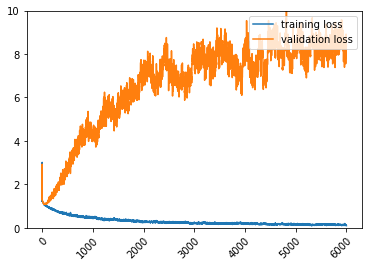

Epoch: 0000 loss_train: 1.2394 loss_val: 1.2833
Epoch: 0050 loss_train: 1.1129 loss_val: 1.1491
Epoch: 0100 loss_train: 0.9540 loss_val: 1.2701
Epoch: 0150 loss_train: 0.8337 loss_val: 1.3479
Epoch: 0200 loss_train: 0.7898 loss_val: 1.5036
Epoch: 0250 loss_train: 0.7502 loss_val: 1.8245
Epoch: 0300 loss_train: 0.6628 loss_val: 2.2244
Epoch: 0350 loss_train: 0.6481 loss_val: 1.6221
Epoch: 0400 loss_train: 0.5731 loss_val: 2.0712
Epoch: 0450 loss_train: 0.5608 loss_val: 2.4812
Epoch: 0500 loss_train: 0.4931 loss_val: 2.9561
Epoch: 0550 loss_train: 0.5228 loss_val: 2.2635
Epoch: 0600 loss_train: 0.5818 loss_val: 2.1378
Epoch: 0650 loss_train: 0.4629 loss_val: 2.9123
Epoch: 0700 loss_train: 0.4913 loss_val: 2.6771
Epoch: 0750 loss_train: 0.4611 loss_val: 2.7263
Epoch: 0800 loss_train: 0.5748 loss_val: 2.4037
Epoch: 0850 loss_train: 0.4916 loss_val: 3.1956
Epoch: 0900 loss_train: 0.4060 loss_val: 2.9521
Epoch: 0950 loss_train: 0.4514 loss_val: 2.8457
Epoch: 1000 loss_train: 0.4289 loss_val:

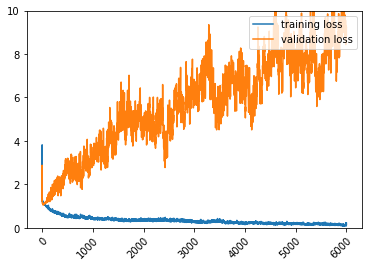

Epoch: 0000 loss_train: 1.2425 loss_val: 1.2772
Epoch: 0050 loss_train: 1.0384 loss_val: 1.0844
Epoch: 0100 loss_train: 0.9469 loss_val: 1.2109
Epoch: 0150 loss_train: 0.8861 loss_val: 1.2338
Epoch: 0200 loss_train: 0.8866 loss_val: 1.3250
Epoch: 0250 loss_train: 0.8574 loss_val: 1.4958
Epoch: 0300 loss_train: 0.7829 loss_val: 1.5320
Epoch: 0350 loss_train: 0.7416 loss_val: 1.8246
Epoch: 0400 loss_train: 0.7286 loss_val: 1.9277
Epoch: 0450 loss_train: 0.6783 loss_val: 2.2756
Epoch: 0500 loss_train: 0.6971 loss_val: 2.5884
Epoch: 0550 loss_train: 0.6109 loss_val: 2.8917
Epoch: 0600 loss_train: 0.6150 loss_val: 3.3045
Epoch: 0650 loss_train: 0.5954 loss_val: 3.0053
Epoch: 0700 loss_train: 0.5819 loss_val: 2.8549
Epoch: 0750 loss_train: 0.5638 loss_val: 3.6581
Epoch: 0800 loss_train: 0.5864 loss_val: 4.2209
Epoch: 0850 loss_train: 0.5589 loss_val: 3.1080
Epoch: 0900 loss_train: 0.5342 loss_val: 3.3757
Epoch: 0950 loss_train: 0.5470 loss_val: 3.6255
Epoch: 1000 loss_train: 0.4987 loss_val:

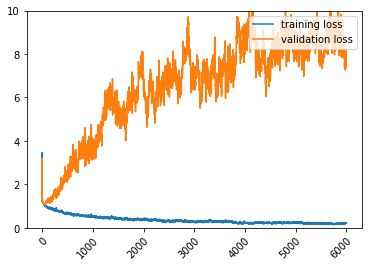

Epoch: 0000 loss_train: 1.2467 loss_val: 1.2484
Epoch: 0050 loss_train: 1.0365 loss_val: 1.0984
Epoch: 0100 loss_train: 0.9028 loss_val: 1.2687
Epoch: 0150 loss_train: 0.8731 loss_val: 1.4109
Epoch: 0200 loss_train: 0.7678 loss_val: 1.4875
Epoch: 0250 loss_train: 0.6595 loss_val: 1.8767
Epoch: 0300 loss_train: 0.6229 loss_val: 1.6166
Epoch: 0350 loss_train: 0.6356 loss_val: 1.5573
Epoch: 0400 loss_train: 0.5204 loss_val: 2.1090
Epoch: 0450 loss_train: 0.4497 loss_val: 2.3794
Epoch: 0500 loss_train: 0.4711 loss_val: 2.5340
Epoch: 0550 loss_train: 0.4214 loss_val: 2.6774
Epoch: 0600 loss_train: 0.3755 loss_val: 3.2577
Epoch: 0650 loss_train: 0.3057 loss_val: 3.4041
Epoch: 0700 loss_train: 0.3732 loss_val: 3.3609
Epoch: 0750 loss_train: 0.4105 loss_val: 3.2885
Epoch: 0800 loss_train: 0.3688 loss_val: 3.6876
Epoch: 0850 loss_train: 0.3617 loss_val: 3.6882
Epoch: 0900 loss_train: 0.2903 loss_val: 4.4296
Epoch: 0950 loss_train: 0.3579 loss_val: 4.2080
Epoch: 1000 loss_train: 0.2871 loss_val:

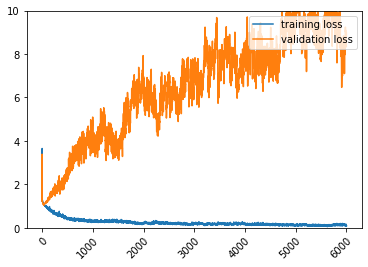

Epoch: 0000 loss_train: 1.2346 loss_val: 2.3118
Epoch: 0050 loss_train: 0.7823 loss_val: 1.3738
Epoch: 0100 loss_train: 0.6867 loss_val: 1.4738
Epoch: 0150 loss_train: 0.5864 loss_val: 1.4700
Epoch: 0200 loss_train: 0.6017 loss_val: 1.4260
Epoch: 0250 loss_train: 0.5580 loss_val: 1.4671
Epoch: 0300 loss_train: 0.6130 loss_val: 1.5986
Epoch: 0350 loss_train: 0.5219 loss_val: 1.5332
Epoch: 0400 loss_train: 0.4520 loss_val: 1.8704
Epoch: 0450 loss_train: 0.4624 loss_val: 1.7761
Epoch: 0500 loss_train: 0.4513 loss_val: 1.7982
Epoch: 0550 loss_train: 0.4612 loss_val: 1.7606
Epoch: 0600 loss_train: 0.4641 loss_val: 1.8716
Epoch: 0650 loss_train: 0.5003 loss_val: 1.8109
Epoch: 0700 loss_train: 0.4448 loss_val: 2.0971
Epoch: 0750 loss_train: 0.4037 loss_val: 2.0658
Epoch: 0800 loss_train: 0.4331 loss_val: 2.2106
Epoch: 0850 loss_train: 0.3906 loss_val: 2.3181
Epoch: 0900 loss_train: 0.3785 loss_val: 2.3110
Epoch: 0950 loss_train: 0.3522 loss_val: 2.1498
Epoch: 1000 loss_train: 0.3766 loss_val:

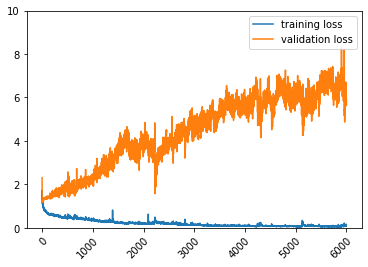

Epoch: 0000 loss_train: 1.1811 loss_val: 1.3407
Epoch: 0050 loss_train: 0.9186 loss_val: 1.3251
Epoch: 0100 loss_train: 0.7160 loss_val: 1.8124
Epoch: 0150 loss_train: 0.6503 loss_val: 2.4133
Epoch: 0200 loss_train: 0.5616 loss_val: 3.4009
Epoch: 0250 loss_train: 0.4606 loss_val: 3.5901
Epoch: 0300 loss_train: 0.4689 loss_val: 3.8439
Epoch: 0350 loss_train: 0.4523 loss_val: 4.7219
Epoch: 0400 loss_train: 0.4435 loss_val: 4.3652
Epoch: 0450 loss_train: 0.3502 loss_val: 5.9308
Epoch: 0500 loss_train: 0.3586 loss_val: 6.6294
Epoch: 0550 loss_train: 0.3574 loss_val: 6.5645
Epoch: 0600 loss_train: 0.2944 loss_val: 7.4114
Epoch: 0650 loss_train: 0.2319 loss_val: 6.6811
Epoch: 0700 loss_train: 0.2125 loss_val: 9.1851
Epoch: 0750 loss_train: 0.3099 loss_val: 7.0523
Epoch: 0800 loss_train: 0.2509 loss_val: 7.9566
Epoch: 0850 loss_train: 0.2829 loss_val: 8.1505
Epoch: 0900 loss_train: 0.2560 loss_val: 9.0993
Epoch: 0950 loss_train: 0.1768 loss_val: 10.7497
Epoch: 1000 loss_train: 0.1902 loss_val

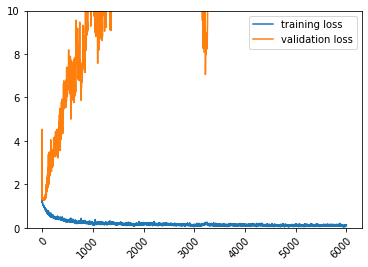

Epoch: 0000 loss_train: 1.1722 loss_val: 1.1563
Epoch: 0050 loss_train: 0.9834 loss_val: 0.9913
Epoch: 0100 loss_train: 0.8950 loss_val: 1.0690
Epoch: 0150 loss_train: 0.7590 loss_val: 1.5636
Epoch: 0200 loss_train: 0.6910 loss_val: 1.4138
Epoch: 0250 loss_train: 0.6773 loss_val: 1.6886
Epoch: 0300 loss_train: 0.5360 loss_val: 1.6820
Epoch: 0350 loss_train: 0.4901 loss_val: 1.8199
Epoch: 0400 loss_train: 0.5183 loss_val: 1.9068
Epoch: 0450 loss_train: 0.4794 loss_val: 2.0738
Epoch: 0500 loss_train: 0.4616 loss_val: 1.8588
Epoch: 0550 loss_train: 0.4339 loss_val: 2.1134
Epoch: 0600 loss_train: 0.3781 loss_val: 2.2376
Epoch: 0650 loss_train: 0.4425 loss_val: 2.4476
Epoch: 0700 loss_train: 0.4130 loss_val: 2.1149
Epoch: 0750 loss_train: 0.3346 loss_val: 2.5051
Epoch: 0800 loss_train: 0.3306 loss_val: 2.4309
Epoch: 0850 loss_train: 0.2991 loss_val: 2.6031
Epoch: 0900 loss_train: 0.3057 loss_val: 2.4075
Epoch: 0950 loss_train: 0.3347 loss_val: 2.4362
Epoch: 1000 loss_train: 0.2772 loss_val:

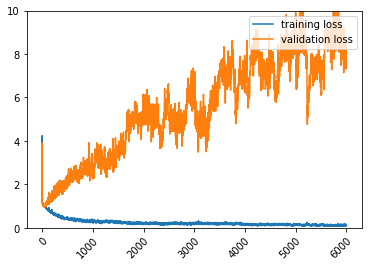

Epoch: 0000 loss_train: 1.2424 loss_val: 1.2936
Epoch: 0050 loss_train: 1.0514 loss_val: 1.0611
Epoch: 0100 loss_train: 0.9193 loss_val: 1.0836
Epoch: 0150 loss_train: 0.8069 loss_val: 1.2554
Epoch: 0200 loss_train: 0.7439 loss_val: 1.1761
Epoch: 0250 loss_train: 0.6721 loss_val: 1.4245
Epoch: 0300 loss_train: 0.7061 loss_val: 1.2377
Epoch: 0350 loss_train: 0.7202 loss_val: 1.6917
Epoch: 0400 loss_train: 0.6024 loss_val: 1.6878
Epoch: 0450 loss_train: 0.5637 loss_val: 1.6851
Epoch: 0500 loss_train: 0.5987 loss_val: 1.7482
Epoch: 0550 loss_train: 0.5282 loss_val: 2.2232
Epoch: 0600 loss_train: 0.5247 loss_val: 2.3901
Epoch: 0650 loss_train: 0.4404 loss_val: 2.8674
Epoch: 0700 loss_train: 0.4043 loss_val: 2.7803
Epoch: 0750 loss_train: 0.4480 loss_val: 2.7576
Epoch: 0800 loss_train: 0.4117 loss_val: 3.5787
Epoch: 0850 loss_train: 0.4251 loss_val: 3.5473
Epoch: 0900 loss_train: 0.3814 loss_val: 3.5490
Epoch: 0950 loss_train: 0.3758 loss_val: 4.4282
Epoch: 1000 loss_train: 0.3997 loss_val:

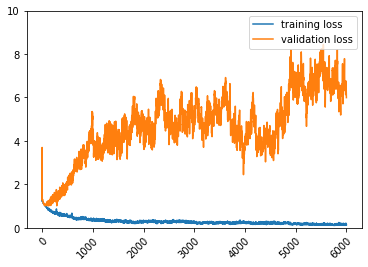

Epoch: 0000 loss_train: 1.1136 loss_val: 1.0591
Epoch: 0050 loss_train: 0.9090 loss_val: 1.0089
Epoch: 0100 loss_train: 0.7894 loss_val: 1.1517
Epoch: 0150 loss_train: 0.6718 loss_val: 1.3179
Epoch: 0200 loss_train: 0.6299 loss_val: 1.5703
Epoch: 0250 loss_train: 0.5267 loss_val: 1.6836
Epoch: 0300 loss_train: 0.4892 loss_val: 1.8082
Epoch: 0350 loss_train: 0.4270 loss_val: 2.1302
Epoch: 0400 loss_train: 0.4401 loss_val: 1.9202
Epoch: 0450 loss_train: 0.3654 loss_val: 2.1444
Epoch: 0500 loss_train: 0.3690 loss_val: 2.3326
Epoch: 0550 loss_train: 0.3135 loss_val: 2.4214
Epoch: 0600 loss_train: 0.2853 loss_val: 2.4092
Epoch: 0650 loss_train: 0.2889 loss_val: 2.4347
Epoch: 0700 loss_train: 0.3146 loss_val: 2.3424
Epoch: 0750 loss_train: 0.3320 loss_val: 2.4332
Epoch: 0800 loss_train: 0.2634 loss_val: 3.0912
Epoch: 0850 loss_train: 0.2471 loss_val: 2.6726
Epoch: 0900 loss_train: 0.2388 loss_val: 2.8486
Epoch: 0950 loss_train: 0.2192 loss_val: 3.0258
Epoch: 1000 loss_train: 0.2666 loss_val:

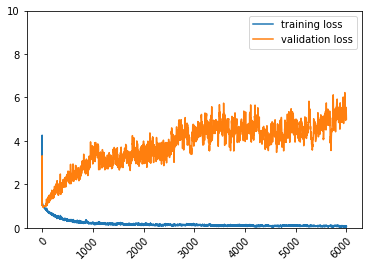

Epoch: 0000 loss_train: 1.2251 loss_val: 1.5130
Epoch: 0050 loss_train: 0.9536 loss_val: 1.0131
Epoch: 0100 loss_train: 0.8388 loss_val: 1.0716
Epoch: 0150 loss_train: 0.7957 loss_val: 1.1201
Epoch: 0200 loss_train: 0.7064 loss_val: 1.2432
Epoch: 0250 loss_train: 0.6946 loss_val: 1.1678
Epoch: 0300 loss_train: 0.6598 loss_val: 1.1932
Epoch: 0350 loss_train: 0.6242 loss_val: 1.2965
Epoch: 0400 loss_train: 0.5765 loss_val: 1.3125
Epoch: 0450 loss_train: 0.5679 loss_val: 1.4076
Epoch: 0500 loss_train: 0.5733 loss_val: 1.4297
Epoch: 0550 loss_train: 0.5409 loss_val: 1.4638
Epoch: 0600 loss_train: 0.5188 loss_val: 1.5638
Epoch: 0650 loss_train: 0.4680 loss_val: 1.5839
Epoch: 0700 loss_train: 0.4638 loss_val: 1.6671
Epoch: 0750 loss_train: 0.5153 loss_val: 1.6849
Epoch: 0800 loss_train: 0.5119 loss_val: 1.4946
Epoch: 0850 loss_train: 0.4604 loss_val: 1.7212
Epoch: 0900 loss_train: 0.4479 loss_val: 1.8033
Epoch: 0950 loss_train: 0.4167 loss_val: 1.9227
Epoch: 1000 loss_train: 0.3899 loss_val:

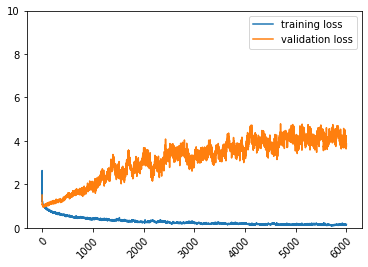

Epoch: 0000 loss_train: 1.1254 loss_val: 2.6339
Epoch: 0050 loss_train: 0.9286 loss_val: 0.9642
Epoch: 0100 loss_train: 0.8479 loss_val: 1.0299
Epoch: 0150 loss_train: 0.7959 loss_val: 1.1143
Epoch: 0200 loss_train: 0.7516 loss_val: 1.2372
Epoch: 0250 loss_train: 0.7043 loss_val: 1.3506
Epoch: 0300 loss_train: 0.6663 loss_val: 1.4743
Epoch: 0350 loss_train: 0.6197 loss_val: 1.6183
Epoch: 0400 loss_train: 0.5861 loss_val: 1.5991
Epoch: 0450 loss_train: 0.5618 loss_val: 1.7392
Epoch: 0500 loss_train: 0.5441 loss_val: 1.7477
Epoch: 0550 loss_train: 0.5122 loss_val: 1.9977
Epoch: 0600 loss_train: 0.4922 loss_val: 2.0394
Epoch: 0650 loss_train: 0.4704 loss_val: 2.2059
Epoch: 0700 loss_train: 0.4972 loss_val: 1.8112
Epoch: 0750 loss_train: 0.4330 loss_val: 2.1159
Epoch: 0800 loss_train: 0.4356 loss_val: 2.1835
Epoch: 0850 loss_train: 0.4033 loss_val: 2.4013
Epoch: 0900 loss_train: 0.3986 loss_val: 2.3864
Epoch: 0950 loss_train: 0.4053 loss_val: 2.3069
Epoch: 1000 loss_train: 0.3888 loss_val:

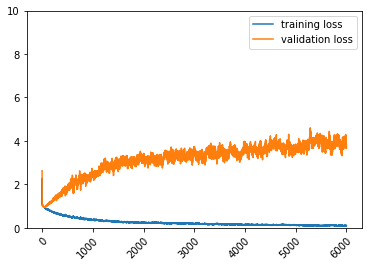

Epoch: 0000 loss_train: 1.1344 loss_val: 1.2161
Epoch: 0050 loss_train: 0.9597 loss_val: 1.0200
Epoch: 0100 loss_train: 0.8562 loss_val: 1.1791
Epoch: 0150 loss_train: 0.8001 loss_val: 1.4049
Epoch: 0200 loss_train: 0.7243 loss_val: 1.5867
Epoch: 0250 loss_train: 0.6186 loss_val: 1.6475
Epoch: 0300 loss_train: 0.5796 loss_val: 1.8758
Epoch: 0350 loss_train: 0.6161 loss_val: 1.7158
Epoch: 0400 loss_train: 0.5190 loss_val: 2.2616
Epoch: 0450 loss_train: 0.4805 loss_val: 2.9196
Epoch: 0500 loss_train: 0.4729 loss_val: 2.7703
Epoch: 0550 loss_train: 0.3821 loss_val: 2.6749
Epoch: 0600 loss_train: 0.4052 loss_val: 2.9851
Epoch: 0650 loss_train: 0.3521 loss_val: 3.3209
Epoch: 0700 loss_train: 0.4621 loss_val: 2.3823
Epoch: 0750 loss_train: 0.3879 loss_val: 3.3645
Epoch: 0800 loss_train: 0.3657 loss_val: 3.1552
Epoch: 0850 loss_train: 0.3395 loss_val: 3.1150
Epoch: 0900 loss_train: 0.3339 loss_val: 3.1049
Epoch: 0950 loss_train: 0.3410 loss_val: 2.7549
Epoch: 1000 loss_train: 0.3188 loss_val:

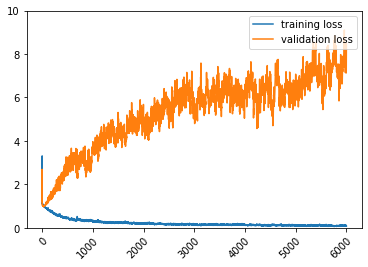

Epoch: 0000 loss_train: 1.1591 loss_val: 1.1482
Epoch: 0050 loss_train: 0.9646 loss_val: 0.9293
Epoch: 0100 loss_train: 0.8752 loss_val: 1.0265
Epoch: 0150 loss_train: 0.8045 loss_val: 1.1190
Epoch: 0200 loss_train: 0.7375 loss_val: 1.1399
Epoch: 0250 loss_train: 0.6351 loss_val: 1.2978
Epoch: 0300 loss_train: 0.5747 loss_val: 1.5989
Epoch: 0350 loss_train: 0.5361 loss_val: 1.5491
Epoch: 0400 loss_train: 0.5559 loss_val: 1.4206
Epoch: 0450 loss_train: 0.4408 loss_val: 1.8055
Epoch: 0500 loss_train: 0.4674 loss_val: 1.7610
Epoch: 0550 loss_train: 0.4201 loss_val: 1.7582
Epoch: 0600 loss_train: 0.4281 loss_val: 2.0329
Epoch: 0650 loss_train: 0.3667 loss_val: 2.3289
Epoch: 0700 loss_train: 0.3324 loss_val: 2.3197
Epoch: 0750 loss_train: 0.3493 loss_val: 2.5145
Epoch: 0800 loss_train: 0.3283 loss_val: 2.2347
Epoch: 0850 loss_train: 0.3679 loss_val: 2.6233
Epoch: 0900 loss_train: 0.3085 loss_val: 2.5228
Epoch: 0950 loss_train: 0.3000 loss_val: 2.5795
Epoch: 1000 loss_train: 0.3125 loss_val:

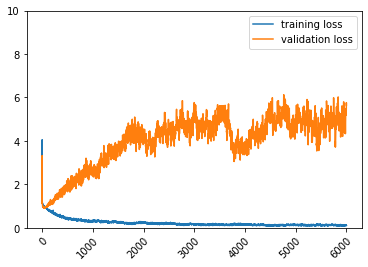

Epoch: 0000 loss_train: 1.0784 loss_val: 1.1493
Epoch: 0050 loss_train: 0.9424 loss_val: 1.0956
Epoch: 0100 loss_train: 0.8495 loss_val: 1.1529
Epoch: 0150 loss_train: 0.8014 loss_val: 1.1240
Epoch: 0200 loss_train: 0.7458 loss_val: 1.1194
Epoch: 0250 loss_train: 0.6580 loss_val: 1.2362
Epoch: 0300 loss_train: 0.6344 loss_val: 1.1733
Epoch: 0350 loss_train: 0.5793 loss_val: 1.4984
Epoch: 0400 loss_train: 0.4905 loss_val: 1.7896
Epoch: 0450 loss_train: 0.4951 loss_val: 1.4777
Epoch: 0500 loss_train: 0.5595 loss_val: 1.7858
Epoch: 0550 loss_train: 0.4241 loss_val: 1.8800
Epoch: 0600 loss_train: 0.4018 loss_val: 2.0094
Epoch: 0650 loss_train: 0.4043 loss_val: 2.0026
Epoch: 0700 loss_train: 0.3645 loss_val: 2.2475
Epoch: 0750 loss_train: 0.3815 loss_val: 2.0443
Epoch: 0800 loss_train: 0.3981 loss_val: 1.9390
Epoch: 0850 loss_train: 0.3777 loss_val: 2.0392
Epoch: 0900 loss_train: 0.3657 loss_val: 2.1204
Epoch: 0950 loss_train: 0.3464 loss_val: 2.2499
Epoch: 1000 loss_train: 0.3116 loss_val:

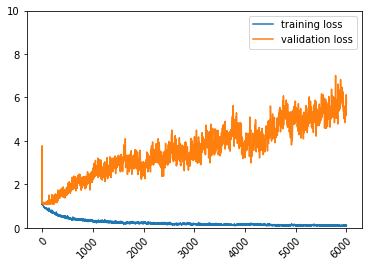

Epoch: 0000 loss_train: 1.1624 loss_val: 1.1943
Epoch: 0050 loss_train: 0.9601 loss_val: 1.0339
Epoch: 0100 loss_train: 0.8509 loss_val: 1.3254
Epoch: 0150 loss_train: 0.7199 loss_val: 1.4104
Epoch: 0200 loss_train: 0.5858 loss_val: 1.7771
Epoch: 0250 loss_train: 0.6606 loss_val: 2.3021
Epoch: 0300 loss_train: 0.4872 loss_val: 2.5834
Epoch: 0350 loss_train: 0.5170 loss_val: 3.0067
Epoch: 0400 loss_train: 0.4118 loss_val: 2.7472
Epoch: 0450 loss_train: 0.4296 loss_val: 3.1409
Epoch: 0500 loss_train: 0.3970 loss_val: 3.3975
Epoch: 0550 loss_train: 0.3731 loss_val: 3.4919
Epoch: 0600 loss_train: 0.3410 loss_val: 3.2282
Epoch: 0650 loss_train: 0.3388 loss_val: 2.7033
Epoch: 0700 loss_train: 0.3209 loss_val: 3.7335
Epoch: 0750 loss_train: 0.3288 loss_val: 3.2927
Epoch: 0800 loss_train: 0.2967 loss_val: 3.8403
Epoch: 0850 loss_train: 0.2718 loss_val: 3.5266
Epoch: 0900 loss_train: 0.2614 loss_val: 4.0632
Epoch: 0950 loss_train: 0.2634 loss_val: 4.0144
Epoch: 1000 loss_train: 0.2900 loss_val:

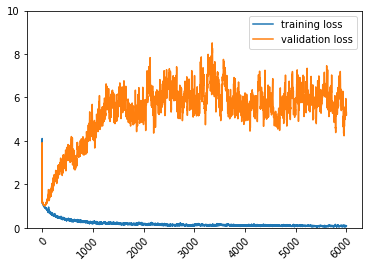

Epoch: 0000 loss_train: 0.9852 loss_val: 1.0096
Epoch: 0050 loss_train: 0.8289 loss_val: 1.0440
Epoch: 0100 loss_train: 0.7177 loss_val: 1.0959
Epoch: 0150 loss_train: 0.6284 loss_val: 1.3814
Epoch: 0200 loss_train: 0.5634 loss_val: 1.5990
Epoch: 0250 loss_train: 0.4937 loss_val: 1.5577
Epoch: 0300 loss_train: 0.4465 loss_val: 1.9155
Epoch: 0350 loss_train: 0.4286 loss_val: 1.9300
Epoch: 0400 loss_train: 0.3795 loss_val: 2.1455
Epoch: 0450 loss_train: 0.3798 loss_val: 2.1918
Epoch: 0500 loss_train: 0.3528 loss_val: 2.4343
Epoch: 0550 loss_train: 0.3304 loss_val: 2.6007
Epoch: 0600 loss_train: 0.3084 loss_val: 2.4615
Epoch: 0650 loss_train: 0.3006 loss_val: 3.0502
Epoch: 0700 loss_train: 0.2919 loss_val: 3.0581
Epoch: 0750 loss_train: 0.2572 loss_val: 3.1147
Epoch: 0800 loss_train: 0.3067 loss_val: 3.0883
Epoch: 0850 loss_train: 0.2716 loss_val: 3.3248
Epoch: 0900 loss_train: 0.2836 loss_val: 3.2924
Epoch: 0950 loss_train: 0.2509 loss_val: 3.4288
Epoch: 1000 loss_train: 0.2383 loss_val:

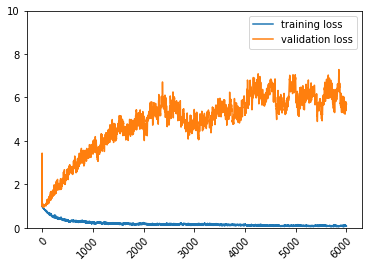

Epoch: 0000 loss_train: 1.0941 loss_val: 1.1269
Epoch: 0050 loss_train: 0.9242 loss_val: 0.9682
Epoch: 0100 loss_train: 0.8365 loss_val: 1.0332
Epoch: 0150 loss_train: 0.7524 loss_val: 1.1067
Epoch: 0200 loss_train: 0.6969 loss_val: 1.2723
Epoch: 0250 loss_train: 0.6759 loss_val: 1.2500
Epoch: 0300 loss_train: 0.5771 loss_val: 1.5345
Epoch: 0350 loss_train: 0.5042 loss_val: 1.7409
Epoch: 0400 loss_train: 0.4947 loss_val: 1.7197
Epoch: 0450 loss_train: 0.5050 loss_val: 1.9070
Epoch: 0500 loss_train: 0.4367 loss_val: 1.7083
Epoch: 0550 loss_train: 0.3968 loss_val: 1.9272
Epoch: 0600 loss_train: 0.3902 loss_val: 2.3253
Epoch: 0650 loss_train: 0.3736 loss_val: 2.0459
Epoch: 0700 loss_train: 0.3734 loss_val: 2.3488
Epoch: 0750 loss_train: 0.3362 loss_val: 2.0843
Epoch: 0800 loss_train: 0.3154 loss_val: 2.3285
Epoch: 0850 loss_train: 0.3368 loss_val: 2.7292
Epoch: 0900 loss_train: 0.3479 loss_val: 2.6455
Epoch: 0950 loss_train: 0.2860 loss_val: 2.3713
Epoch: 1000 loss_train: 0.3142 loss_val:

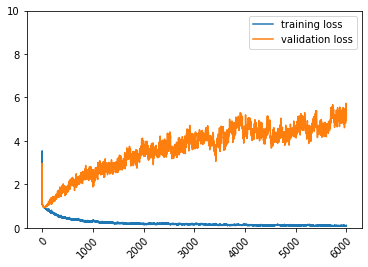

Epoch: 0000 loss_train: 1.0805 loss_val: 1.1094
Epoch: 0050 loss_train: 0.9197 loss_val: 0.9705
Epoch: 0100 loss_train: 0.8478 loss_val: 0.9663
Epoch: 0150 loss_train: 0.7127 loss_val: 1.0290
Epoch: 0200 loss_train: 0.6341 loss_val: 1.0615
Epoch: 0250 loss_train: 0.5644 loss_val: 1.2070
Epoch: 0300 loss_train: 0.5506 loss_val: 1.3569
Epoch: 0350 loss_train: 0.4829 loss_val: 1.5892
Epoch: 0400 loss_train: 0.4923 loss_val: 1.6057
Epoch: 0450 loss_train: 0.4213 loss_val: 1.9921
Epoch: 0500 loss_train: 0.3890 loss_val: 1.9324
Epoch: 0550 loss_train: 0.3891 loss_val: 2.1456
Epoch: 0600 loss_train: 0.3505 loss_val: 2.5929
Epoch: 0650 loss_train: 0.3453 loss_val: 2.7526
Epoch: 0700 loss_train: 0.2962 loss_val: 2.4336
Epoch: 0750 loss_train: 0.2990 loss_val: 2.9292
Epoch: 0800 loss_train: 0.2980 loss_val: 3.1995
Epoch: 0850 loss_train: 0.2678 loss_val: 2.9095
Epoch: 0900 loss_train: 0.2863 loss_val: 3.1015
Epoch: 0950 loss_train: 0.2474 loss_val: 3.1265
Epoch: 1000 loss_train: 0.2832 loss_val:

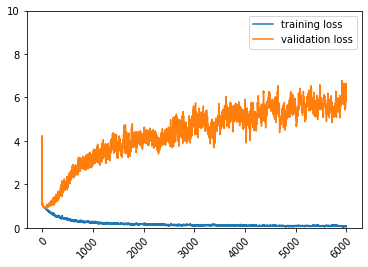

Epoch: 0000 loss_train: 1.0855 loss_val: 1.0627
Epoch: 0050 loss_train: 0.8690 loss_val: 0.8124
Epoch: 0100 loss_train: 0.8412 loss_val: 0.8070
Epoch: 0150 loss_train: 0.7063 loss_val: 0.9480
Epoch: 0200 loss_train: 0.6474 loss_val: 0.9710
Epoch: 0250 loss_train: 0.4909 loss_val: 1.0312
Epoch: 0300 loss_train: 0.4622 loss_val: 1.0900
Epoch: 0350 loss_train: 0.4239 loss_val: 1.2594
Epoch: 0400 loss_train: 0.4388 loss_val: 1.3394
Epoch: 0450 loss_train: 0.3799 loss_val: 1.4013
Epoch: 0500 loss_train: 0.3652 loss_val: 1.3837
Epoch: 0550 loss_train: 0.3743 loss_val: 1.2677
Epoch: 0600 loss_train: 0.2913 loss_val: 1.3416
Epoch: 0650 loss_train: 0.2357 loss_val: 1.5528
Epoch: 0700 loss_train: 0.2494 loss_val: 1.7394
Epoch: 0750 loss_train: 0.2559 loss_val: 1.2954
Epoch: 0800 loss_train: 0.2657 loss_val: 1.7806
Epoch: 0850 loss_train: 0.2244 loss_val: 1.7247
Epoch: 0900 loss_train: 0.2363 loss_val: 1.4646
Epoch: 0950 loss_train: 0.2729 loss_val: 1.8746
Epoch: 1000 loss_train: 0.2309 loss_val:

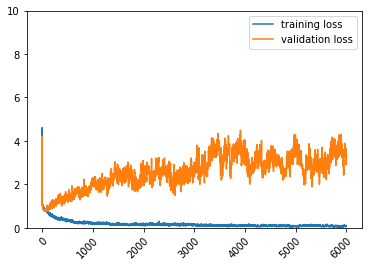

Epoch: 0000 loss_train: 1.1877 loss_val: 1.2414
Epoch: 0050 loss_train: 0.9271 loss_val: 1.1947
Epoch: 0100 loss_train: 0.8265 loss_val: 1.3595
Epoch: 0150 loss_train: 0.6747 loss_val: 1.7936
Epoch: 0200 loss_train: 0.6015 loss_val: 1.8823
Epoch: 0250 loss_train: 0.5446 loss_val: 2.0155
Epoch: 0300 loss_train: 0.5488 loss_val: 2.0746
Epoch: 0350 loss_train: 0.4729 loss_val: 2.3787
Epoch: 0400 loss_train: 0.4294 loss_val: 2.6007
Epoch: 0450 loss_train: 0.4251 loss_val: 2.4533
Epoch: 0500 loss_train: 0.4469 loss_val: 2.9442
Epoch: 0550 loss_train: 0.3542 loss_val: 2.7405
Epoch: 0600 loss_train: 0.3093 loss_val: 3.4063
Epoch: 0650 loss_train: 0.3301 loss_val: 3.6306
Epoch: 0700 loss_train: 0.3200 loss_val: 3.3707
Epoch: 0750 loss_train: 0.3120 loss_val: 3.2455
Epoch: 0800 loss_train: 0.2589 loss_val: 3.4216
Epoch: 0850 loss_train: 0.2419 loss_val: 4.1218
Epoch: 0900 loss_train: 0.2374 loss_val: 4.8871
Epoch: 0950 loss_train: 0.2297 loss_val: 4.5807
Epoch: 1000 loss_train: 0.2281 loss_val:

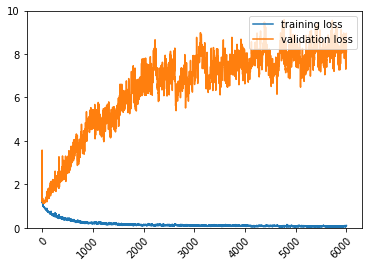

Epoch: 0000 loss_train: 1.0601 loss_val: 1.0112
Epoch: 0050 loss_train: 0.8429 loss_val: 0.7893
Epoch: 0100 loss_train: 0.7929 loss_val: 0.8395
Epoch: 0150 loss_train: 0.6148 loss_val: 1.0031
Epoch: 0200 loss_train: 0.5241 loss_val: 1.0639
Epoch: 0250 loss_train: 0.4914 loss_val: 1.0598
Epoch: 0300 loss_train: 0.3978 loss_val: 1.1478
Epoch: 0350 loss_train: 0.3792 loss_val: 1.2030
Epoch: 0400 loss_train: 0.3657 loss_val: 1.1777
Epoch: 0450 loss_train: 0.3144 loss_val: 1.3022
Epoch: 0500 loss_train: 0.3182 loss_val: 1.3200
Epoch: 0550 loss_train: 0.3171 loss_val: 1.3709
Epoch: 0600 loss_train: 0.2774 loss_val: 1.5084
Epoch: 0650 loss_train: 0.2575 loss_val: 1.4248
Epoch: 0700 loss_train: 0.2808 loss_val: 1.2976
Epoch: 0750 loss_train: 0.2633 loss_val: 1.0906
Epoch: 0800 loss_train: 0.2127 loss_val: 1.4388
Epoch: 0850 loss_train: 0.1995 loss_val: 1.4324
Epoch: 0900 loss_train: 0.2573 loss_val: 1.5086
Epoch: 0950 loss_train: 0.2021 loss_val: 1.4215
Epoch: 1000 loss_train: 0.2348 loss_val:

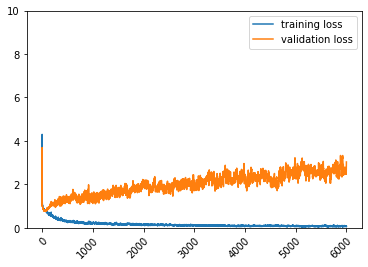

Epoch: 0000 loss_train: 0.9637 loss_val: 1.1123
Epoch: 0050 loss_train: 0.8016 loss_val: 0.8216
Epoch: 0100 loss_train: 0.7246 loss_val: 0.8910
Epoch: 0150 loss_train: 0.5960 loss_val: 0.8744
Epoch: 0200 loss_train: 0.5415 loss_val: 0.9054
Epoch: 0250 loss_train: 0.4872 loss_val: 1.0043
Epoch: 0300 loss_train: 0.4422 loss_val: 1.0812
Epoch: 0350 loss_train: 0.3831 loss_val: 1.0746
Epoch: 0400 loss_train: 0.3734 loss_val: 1.1651
Epoch: 0450 loss_train: 0.3501 loss_val: 1.3029
Epoch: 0500 loss_train: 0.3422 loss_val: 1.3246
Epoch: 0550 loss_train: 0.3146 loss_val: 1.3515
Epoch: 0600 loss_train: 0.3058 loss_val: 1.4960
Epoch: 0650 loss_train: 0.3116 loss_val: 1.5141
Epoch: 0700 loss_train: 0.3014 loss_val: 1.5398
Epoch: 0750 loss_train: 0.2749 loss_val: 1.7706
Epoch: 0800 loss_train: 0.2856 loss_val: 1.3899
Epoch: 0850 loss_train: 0.2381 loss_val: 2.0175
Epoch: 0900 loss_train: 0.2269 loss_val: 2.0165
Epoch: 0950 loss_train: 0.2265 loss_val: 1.7528
Epoch: 1000 loss_train: 0.2494 loss_val:

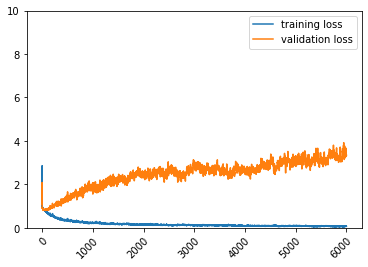

Epoch: 0000 loss_train: 1.0124 loss_val: 1.0754
Epoch: 0050 loss_train: 0.8896 loss_val: 0.9261
Epoch: 0100 loss_train: 0.7837 loss_val: 1.0179
Epoch: 0150 loss_train: 0.7095 loss_val: 1.1384
Epoch: 0200 loss_train: 0.5924 loss_val: 1.3265
Epoch: 0250 loss_train: 0.4928 loss_val: 1.4215
Epoch: 0300 loss_train: 0.5148 loss_val: 1.5035
Epoch: 0350 loss_train: 0.4071 loss_val: 1.8562
Epoch: 0400 loss_train: 0.4036 loss_val: 2.0640
Epoch: 0450 loss_train: 0.4181 loss_val: 1.7197
Epoch: 0500 loss_train: 0.4305 loss_val: 1.6360
Epoch: 0550 loss_train: 0.3297 loss_val: 2.1321
Epoch: 0600 loss_train: 0.3321 loss_val: 2.1591
Epoch: 0650 loss_train: 0.3637 loss_val: 1.9941
Epoch: 0700 loss_train: 0.3160 loss_val: 2.6537
Epoch: 0750 loss_train: 0.3132 loss_val: 2.4373
Epoch: 0800 loss_train: 0.2718 loss_val: 2.6368
Epoch: 0850 loss_train: 0.2738 loss_val: 2.9743
Epoch: 0900 loss_train: 0.2794 loss_val: 3.2691
Epoch: 0950 loss_train: 0.2894 loss_val: 2.6804
Epoch: 1000 loss_train: 0.2587 loss_val:

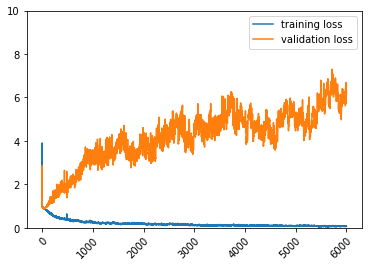

Epoch: 0000 loss_train: 0.9806 loss_val: 1.0181
Epoch: 0050 loss_train: 0.8415 loss_val: 0.9132
Epoch: 0100 loss_train: 0.7393 loss_val: 0.9673
Epoch: 0150 loss_train: 0.6224 loss_val: 1.2160
Epoch: 0200 loss_train: 0.5892 loss_val: 1.1462
Epoch: 0250 loss_train: 0.4657 loss_val: 1.2561
Epoch: 0300 loss_train: 0.4048 loss_val: 1.4822
Epoch: 0350 loss_train: 0.3733 loss_val: 1.5891
Epoch: 0400 loss_train: 0.3469 loss_val: 1.8832
Epoch: 0450 loss_train: 0.3180 loss_val: 1.7614
Epoch: 0500 loss_train: 0.2857 loss_val: 2.0029
Epoch: 0550 loss_train: 0.2747 loss_val: 2.2624
Epoch: 0600 loss_train: 0.2526 loss_val: 2.0379
Epoch: 0650 loss_train: 0.2570 loss_val: 2.0784
Epoch: 0700 loss_train: 0.2751 loss_val: 2.3835
Epoch: 0750 loss_train: 0.2275 loss_val: 2.7137
Epoch: 0800 loss_train: 0.2186 loss_val: 2.9245
Epoch: 0850 loss_train: 0.1928 loss_val: 3.1494
Epoch: 0900 loss_train: 0.2460 loss_val: 2.9069
Epoch: 0950 loss_train: 0.2077 loss_val: 2.7872
Epoch: 1000 loss_train: 0.1953 loss_val:

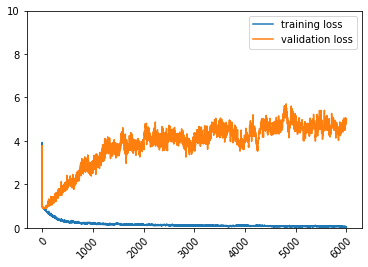

Epoch: 0000 loss_train: 1.0949 loss_val: 1.1148
Epoch: 0050 loss_train: 0.9613 loss_val: 0.9758
Epoch: 0100 loss_train: 0.8769 loss_val: 1.0764
Epoch: 0150 loss_train: 0.7932 loss_val: 1.1082
Epoch: 0200 loss_train: 0.6927 loss_val: 1.2620
Epoch: 0250 loss_train: 0.7104 loss_val: 1.4033
Epoch: 0300 loss_train: 0.6028 loss_val: 1.3940
Epoch: 0350 loss_train: 0.5331 loss_val: 1.6578
Epoch: 0400 loss_train: 0.5166 loss_val: 1.7191
Epoch: 0450 loss_train: 0.4565 loss_val: 1.8735
Epoch: 0500 loss_train: 0.4565 loss_val: 1.8126
Epoch: 0550 loss_train: 0.4140 loss_val: 2.1184
Epoch: 0600 loss_train: 0.3897 loss_val: 2.3664
Epoch: 0650 loss_train: 0.3818 loss_val: 2.3746
Epoch: 0700 loss_train: 0.3523 loss_val: 2.6653
Epoch: 0750 loss_train: 0.3157 loss_val: 2.5328
Epoch: 0800 loss_train: 0.3130 loss_val: 2.8515
Epoch: 0850 loss_train: 0.3083 loss_val: 2.8408
Epoch: 0900 loss_train: 0.3050 loss_val: 2.7426
Epoch: 0950 loss_train: 0.3150 loss_val: 2.7376
Epoch: 1000 loss_train: 0.2574 loss_val:

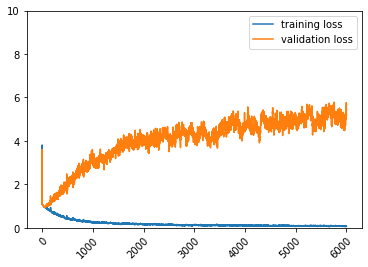

Epoch: 0000 loss_train: 1.0643 loss_val: 1.0645
Epoch: 0050 loss_train: 0.8949 loss_val: 0.9425
Epoch: 0100 loss_train: 0.7642 loss_val: 1.1335
Epoch: 0150 loss_train: 0.7146 loss_val: 1.1808
Epoch: 0200 loss_train: 0.5880 loss_val: 1.2232
Epoch: 0250 loss_train: 0.5242 loss_val: 1.3130
Epoch: 0300 loss_train: 0.4880 loss_val: 1.3277
Epoch: 0350 loss_train: 0.4512 loss_val: 1.1992
Epoch: 0400 loss_train: 0.4252 loss_val: 1.4941
Epoch: 0450 loss_train: 0.3563 loss_val: 1.7579
Epoch: 0500 loss_train: 0.3739 loss_val: 1.7956
Epoch: 0550 loss_train: 0.3416 loss_val: 1.9455
Epoch: 0600 loss_train: 0.3692 loss_val: 2.1578
Epoch: 0650 loss_train: 0.3653 loss_val: 1.9990
Epoch: 0700 loss_train: 0.2918 loss_val: 2.2064
Epoch: 0750 loss_train: 0.3315 loss_val: 2.2196
Epoch: 0800 loss_train: 0.3404 loss_val: 2.1841
Epoch: 0850 loss_train: 0.2774 loss_val: 2.6857
Epoch: 0900 loss_train: 0.2699 loss_val: 2.3133
Epoch: 0950 loss_train: 0.2901 loss_val: 2.2049
Epoch: 1000 loss_train: 0.2588 loss_val:

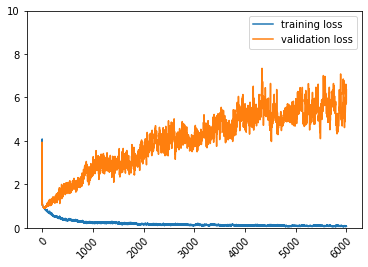

Epoch: 0000 loss_train: 0.9702 loss_val: 1.0236
Epoch: 0050 loss_train: 0.7674 loss_val: 0.7482
Epoch: 0100 loss_train: 0.6559 loss_val: 0.8096
Epoch: 0150 loss_train: 0.5213 loss_val: 0.8655
Epoch: 0200 loss_train: 0.4996 loss_val: 1.2528
Epoch: 0250 loss_train: 0.4499 loss_val: 1.0910
Epoch: 0300 loss_train: 0.4489 loss_val: 1.2312
Epoch: 0350 loss_train: 0.3856 loss_val: 1.9284
Epoch: 0400 loss_train: 0.3270 loss_val: 2.0099
Epoch: 0450 loss_train: 0.2742 loss_val: 2.0452
Epoch: 0500 loss_train: 0.2806 loss_val: 2.1321
Epoch: 0550 loss_train: 0.2669 loss_val: 2.4192
Epoch: 0600 loss_train: 0.2815 loss_val: 2.3670
Epoch: 0650 loss_train: 0.2682 loss_val: 2.5959
Epoch: 0700 loss_train: 0.2291 loss_val: 2.3862
Epoch: 0750 loss_train: 0.2707 loss_val: 2.7030
Epoch: 0800 loss_train: 0.1986 loss_val: 2.9408
Epoch: 0850 loss_train: 0.1948 loss_val: 3.1456
Epoch: 0900 loss_train: 0.2124 loss_val: 3.1434
Epoch: 0950 loss_train: 0.2022 loss_val: 3.1072
Epoch: 1000 loss_train: 0.1660 loss_val:

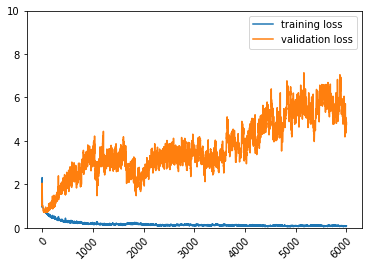

Epoch: 0000 loss_train: 1.0783 loss_val: 1.0741
Epoch: 0050 loss_train: 0.9493 loss_val: 1.0299
Epoch: 0100 loss_train: 0.8860 loss_val: 1.0506
Epoch: 0150 loss_train: 0.7723 loss_val: 1.1125
Epoch: 0200 loss_train: 0.7041 loss_val: 1.2554
Epoch: 0250 loss_train: 0.6530 loss_val: 1.4964
Epoch: 0300 loss_train: 0.6101 loss_val: 1.6526
Epoch: 0350 loss_train: 0.5234 loss_val: 1.8810
Epoch: 0400 loss_train: 0.4648 loss_val: 2.0130
Epoch: 0450 loss_train: 0.4647 loss_val: 2.2707
Epoch: 0500 loss_train: 0.4590 loss_val: 2.3675
Epoch: 0550 loss_train: 0.4039 loss_val: 2.5745
Epoch: 0600 loss_train: 0.3776 loss_val: 2.9256
Epoch: 0650 loss_train: 0.3986 loss_val: 2.6171
Epoch: 0700 loss_train: 0.3632 loss_val: 3.0808
Epoch: 0750 loss_train: 0.3798 loss_val: 2.8289
Epoch: 0800 loss_train: 0.3727 loss_val: 2.8652
Epoch: 0850 loss_train: 0.3380 loss_val: 3.1694
Epoch: 0900 loss_train: 0.3655 loss_val: 3.1829
Epoch: 0950 loss_train: 0.3643 loss_val: 3.5744
Epoch: 1000 loss_train: 0.3002 loss_val:

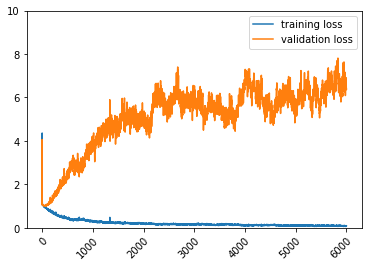

Epoch: 0000 loss_train: 1.0497 loss_val: 1.1421
Epoch: 0050 loss_train: 0.8777 loss_val: 0.9797
Epoch: 0100 loss_train: 0.7540 loss_val: 1.1865
Epoch: 0150 loss_train: 0.6681 loss_val: 1.2667
Epoch: 0200 loss_train: 0.6073 loss_val: 1.5851
Epoch: 0250 loss_train: 0.5523 loss_val: 1.5551
Epoch: 0300 loss_train: 0.4780 loss_val: 1.9484
Epoch: 0350 loss_train: 0.4231 loss_val: 2.0489
Epoch: 0400 loss_train: 0.3892 loss_val: 2.2715
Epoch: 0450 loss_train: 0.3854 loss_val: 2.4083
Epoch: 0500 loss_train: 0.3717 loss_val: 2.5458
Epoch: 0550 loss_train: 0.3166 loss_val: 2.7305
Epoch: 0600 loss_train: 0.3097 loss_val: 2.5089
Epoch: 0650 loss_train: 0.3217 loss_val: 2.9892
Epoch: 0700 loss_train: 0.2798 loss_val: 3.0528
Epoch: 0750 loss_train: 0.3275 loss_val: 2.8593
Epoch: 0800 loss_train: 0.3012 loss_val: 3.0360
Epoch: 0850 loss_train: 0.2296 loss_val: 3.4729
Epoch: 0900 loss_train: 0.2073 loss_val: 3.2173
Epoch: 0950 loss_train: 0.2271 loss_val: 3.0723
Epoch: 1000 loss_train: 0.2212 loss_val:

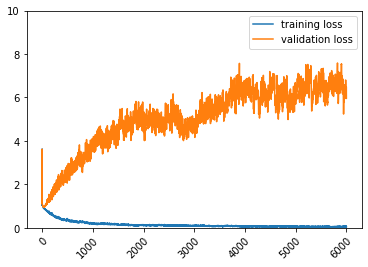

Epoch: 0000 loss_train: 1.0108 loss_val: 1.0491
Epoch: 0050 loss_train: 0.8525 loss_val: 0.9532
Epoch: 0100 loss_train: 0.7369 loss_val: 1.0144
Epoch: 0150 loss_train: 0.6193 loss_val: 1.1156
Epoch: 0200 loss_train: 0.5518 loss_val: 1.2015
Epoch: 0250 loss_train: 0.4865 loss_val: 1.4391
Epoch: 0300 loss_train: 0.4069 loss_val: 1.4374
Epoch: 0350 loss_train: 0.3852 loss_val: 1.7431
Epoch: 0400 loss_train: 0.4946 loss_val: 2.1629
Epoch: 0450 loss_train: 0.3516 loss_val: 1.8896
Epoch: 0500 loss_train: 0.3268 loss_val: 1.8082
Epoch: 0550 loss_train: 0.2750 loss_val: 2.4527
Epoch: 0600 loss_train: 0.3018 loss_val: 2.4588
Epoch: 0650 loss_train: 0.2991 loss_val: 2.4481
Epoch: 0700 loss_train: 0.2933 loss_val: 2.7006
Epoch: 0750 loss_train: 0.2427 loss_val: 2.9766
Epoch: 0800 loss_train: 0.2011 loss_val: 2.4199
Epoch: 0850 loss_train: 0.2197 loss_val: 2.6347
Epoch: 0900 loss_train: 0.1779 loss_val: 3.0359
Epoch: 0950 loss_train: 0.2640 loss_val: 2.5516
Epoch: 1000 loss_train: 0.2014 loss_val:

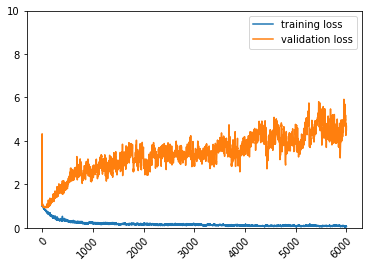

Epoch: 0000 loss_train: 1.1159 loss_val: 0.8950
Epoch: 0050 loss_train: 0.9379 loss_val: 0.8240
Epoch: 0100 loss_train: 0.7033 loss_val: 1.1665
Epoch: 0150 loss_train: 0.6095 loss_val: 1.8209
Epoch: 0200 loss_train: 0.6315 loss_val: 1.8532
Epoch: 0250 loss_train: 0.4799 loss_val: 1.6398
Epoch: 0300 loss_train: 0.3820 loss_val: 2.3980
Epoch: 0350 loss_train: 0.3371 loss_val: 2.0706
Epoch: 0400 loss_train: 0.3938 loss_val: 2.0534
Epoch: 0450 loss_train: 0.3415 loss_val: 2.1442
Epoch: 0500 loss_train: 0.3396 loss_val: 1.9938
Epoch: 0550 loss_train: 0.3928 loss_val: 1.6694
Epoch: 0600 loss_train: 0.2979 loss_val: 2.5228
Epoch: 0650 loss_train: 0.3442 loss_val: 2.1683
Epoch: 0700 loss_train: 0.2883 loss_val: 2.2990
Epoch: 0750 loss_train: 0.2457 loss_val: 2.7913
Epoch: 0800 loss_train: 0.3030 loss_val: 2.5367
Epoch: 0850 loss_train: 0.3658 loss_val: 2.6467
Epoch: 0900 loss_train: 0.2430 loss_val: 2.5911
Epoch: 0950 loss_train: 0.2134 loss_val: 3.9801
Epoch: 1000 loss_train: 0.3163 loss_val:

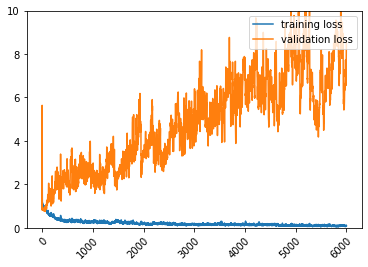

Epoch: 0000 loss_train: 0.8726 loss_val: 0.9497
Epoch: 0050 loss_train: 0.6769 loss_val: 0.7218
Epoch: 0100 loss_train: 0.6175 loss_val: 0.7480
Epoch: 0150 loss_train: 0.5302 loss_val: 0.8241
Epoch: 0200 loss_train: 0.4788 loss_val: 0.8000
Epoch: 0250 loss_train: 0.4889 loss_val: 0.8527
Epoch: 0300 loss_train: 0.3792 loss_val: 1.0224
Epoch: 0350 loss_train: 0.3687 loss_val: 1.0700
Epoch: 0400 loss_train: 0.3204 loss_val: 1.1785
Epoch: 0450 loss_train: 0.3688 loss_val: 1.3390
Epoch: 0500 loss_train: 0.3047 loss_val: 1.2052
Epoch: 0550 loss_train: 0.2742 loss_val: 1.3668
Epoch: 0600 loss_train: 0.2499 loss_val: 1.4688
Epoch: 0650 loss_train: 0.2822 loss_val: 1.2070
Epoch: 0700 loss_train: 0.2125 loss_val: 1.3454
Epoch: 0750 loss_train: 0.2188 loss_val: 1.6458
Epoch: 0800 loss_train: 0.1813 loss_val: 1.8205
Epoch: 0850 loss_train: 0.1879 loss_val: 1.7641
Epoch: 0900 loss_train: 0.1744 loss_val: 1.8559
Epoch: 0950 loss_train: 0.1654 loss_val: 1.7389
Epoch: 1000 loss_train: 0.1580 loss_val:

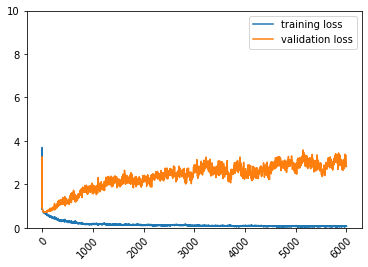

Epoch: 0000 loss_train: 0.9113 loss_val: 0.9574
Epoch: 0050 loss_train: 0.7080 loss_val: 0.7254
Epoch: 0100 loss_train: 0.6212 loss_val: 0.7261
Epoch: 0150 loss_train: 0.5922 loss_val: 0.8005
Epoch: 0200 loss_train: 0.4769 loss_val: 0.8788
Epoch: 0250 loss_train: 0.4501 loss_val: 0.8935
Epoch: 0300 loss_train: 0.4010 loss_val: 1.1082
Epoch: 0350 loss_train: 0.3485 loss_val: 1.2282
Epoch: 0400 loss_train: 0.3265 loss_val: 1.2851
Epoch: 0450 loss_train: 0.3305 loss_val: 1.1263
Epoch: 0500 loss_train: 0.3040 loss_val: 1.3660
Epoch: 0550 loss_train: 0.2825 loss_val: 1.4224
Epoch: 0600 loss_train: 0.2735 loss_val: 1.6719
Epoch: 0650 loss_train: 0.2807 loss_val: 1.4094
Epoch: 0700 loss_train: 0.2284 loss_val: 1.6458
Epoch: 0750 loss_train: 0.2287 loss_val: 1.7092
Epoch: 0800 loss_train: 0.2104 loss_val: 1.7726
Epoch: 0850 loss_train: 0.2098 loss_val: 1.7248
Epoch: 0900 loss_train: 0.2079 loss_val: 1.8226
Epoch: 0950 loss_train: 0.1884 loss_val: 2.0812
Epoch: 1000 loss_train: 0.1902 loss_val:

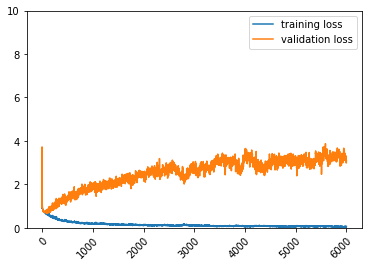

Epoch: 0000 loss_train: 0.6555 loss_val: 0.6178
Epoch: 0050 loss_train: 0.4680 loss_val: 0.4266
Epoch: 0100 loss_train: 0.4264 loss_val: 0.4520
Epoch: 0150 loss_train: 0.3796 loss_val: 0.4875
Epoch: 0200 loss_train: 0.3387 loss_val: 0.5547
Epoch: 0250 loss_train: 0.3139 loss_val: 0.6620
Epoch: 0300 loss_train: 0.3006 loss_val: 0.6528
Epoch: 0350 loss_train: 0.2636 loss_val: 0.6408
Epoch: 0400 loss_train: 0.2448 loss_val: 0.7548
Epoch: 0450 loss_train: 0.2572 loss_val: 0.8456
Epoch: 0500 loss_train: 0.2344 loss_val: 0.8722
Epoch: 0550 loss_train: 0.2511 loss_val: 0.9348
Epoch: 0600 loss_train: 0.2324 loss_val: 0.9724
Epoch: 0650 loss_train: 0.2209 loss_val: 1.1069
Epoch: 0700 loss_train: 0.2250 loss_val: 0.9226
Epoch: 0750 loss_train: 0.1928 loss_val: 1.1965
Epoch: 0800 loss_train: 0.1963 loss_val: 1.0727
Epoch: 0850 loss_train: 0.1779 loss_val: 1.2529
Epoch: 0900 loss_train: 0.1726 loss_val: 1.2767
Epoch: 0950 loss_train: 0.1767 loss_val: 1.3974
Epoch: 1000 loss_train: 0.1725 loss_val:

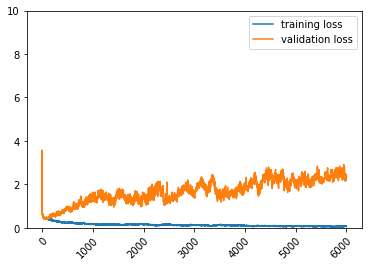

Epoch: 0000 loss_train: 1.0636 loss_val: 1.2309
Epoch: 0050 loss_train: 0.9187 loss_val: 0.9211
Epoch: 0100 loss_train: 0.8346 loss_val: 0.9407
Epoch: 0150 loss_train: 0.7728 loss_val: 0.9521
Epoch: 0200 loss_train: 0.6774 loss_val: 1.1670
Epoch: 0250 loss_train: 0.6085 loss_val: 1.1298
Epoch: 0300 loss_train: 0.5607 loss_val: 1.2274
Epoch: 0350 loss_train: 0.5332 loss_val: 1.3763
Epoch: 0400 loss_train: 0.4898 loss_val: 1.5159
Epoch: 0450 loss_train: 0.4681 loss_val: 1.4224
Epoch: 0500 loss_train: 0.4201 loss_val: 1.6840
Epoch: 0550 loss_train: 0.4408 loss_val: 1.9187
Epoch: 0600 loss_train: 0.4240 loss_val: 1.6940
Epoch: 0650 loss_train: 0.3765 loss_val: 1.9517
Epoch: 0700 loss_train: 0.3535 loss_val: 2.2449
Epoch: 0750 loss_train: 0.3566 loss_val: 2.1420
Epoch: 0800 loss_train: 0.3794 loss_val: 1.6637
Epoch: 0850 loss_train: 0.3455 loss_val: 1.9287
Epoch: 0900 loss_train: 0.3119 loss_val: 2.0939
Epoch: 0950 loss_train: 0.2968 loss_val: 2.5687
Epoch: 1000 loss_train: 0.2981 loss_val:

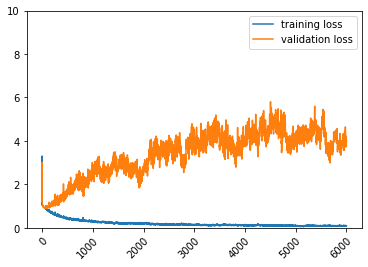

Epoch: 0000 loss_train: 0.9026 loss_val: 0.9192
Epoch: 0050 loss_train: 0.7129 loss_val: 0.6934
Epoch: 0100 loss_train: 0.6181 loss_val: 0.7856
Epoch: 0150 loss_train: 0.5063 loss_val: 0.8642
Epoch: 0200 loss_train: 0.4913 loss_val: 1.1036
Epoch: 0250 loss_train: 0.3773 loss_val: 1.2516
Epoch: 0300 loss_train: 0.3239 loss_val: 1.1748
Epoch: 0350 loss_train: 0.3085 loss_val: 1.1065
Epoch: 0400 loss_train: 0.2976 loss_val: 1.3384
Epoch: 0450 loss_train: 0.2378 loss_val: 1.5259
Epoch: 0500 loss_train: 0.2656 loss_val: 1.5421
Epoch: 0550 loss_train: 0.2027 loss_val: 1.5952
Epoch: 0600 loss_train: 0.1914 loss_val: 1.6226
Epoch: 0650 loss_train: 0.2103 loss_val: 1.7472
Epoch: 0700 loss_train: 0.1669 loss_val: 1.6464
Epoch: 0750 loss_train: 0.1731 loss_val: 1.8470
Epoch: 0800 loss_train: 0.1820 loss_val: 1.8801
Epoch: 0850 loss_train: 0.1812 loss_val: 1.8713
Epoch: 0900 loss_train: 0.1826 loss_val: 1.9875
Epoch: 0950 loss_train: 0.1682 loss_val: 2.0911
Epoch: 1000 loss_train: 0.1746 loss_val:

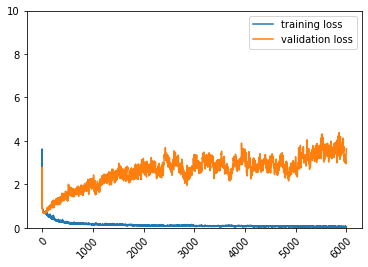

Epoch: 0000 loss_train: 0.8845 loss_val: 0.9553
Epoch: 0050 loss_train: 0.6758 loss_val: 0.6905
Epoch: 0100 loss_train: 0.6122 loss_val: 0.7231
Epoch: 0150 loss_train: 0.5553 loss_val: 0.7929
Epoch: 0200 loss_train: 0.4879 loss_val: 0.8839
Epoch: 0250 loss_train: 0.4616 loss_val: 0.9550
Epoch: 0300 loss_train: 0.4198 loss_val: 1.1253
Epoch: 0350 loss_train: 0.4082 loss_val: 1.1719
Epoch: 0400 loss_train: 0.3629 loss_val: 1.2709
Epoch: 0450 loss_train: 0.3880 loss_val: 1.3086
Epoch: 0500 loss_train: 0.3351 loss_val: 1.4498
Epoch: 0550 loss_train: 0.3220 loss_val: 1.7447
Epoch: 0600 loss_train: 0.3008 loss_val: 1.6518
Epoch: 0650 loss_train: 0.3041 loss_val: 1.7064
Epoch: 0700 loss_train: 0.2803 loss_val: 1.5832
Epoch: 0750 loss_train: 0.2725 loss_val: 1.6293
Epoch: 0800 loss_train: 0.2625 loss_val: 1.5388
Epoch: 0850 loss_train: 0.2367 loss_val: 1.9853
Epoch: 0900 loss_train: 0.2575 loss_val: 1.7993
Epoch: 0950 loss_train: 0.2384 loss_val: 1.7373
Epoch: 1000 loss_train: 0.2246 loss_val:

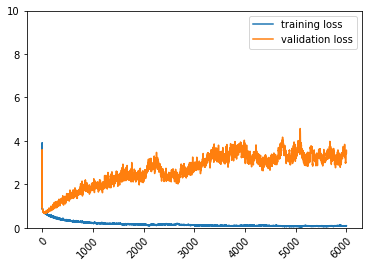

In [96]:
pctVal=0.05
pctTest=0.1

for i in np.unique(clusterRes):
    logsavepath_i=os.path.join(logsavepath,str(i))
    plotsavepath_i=os.path.join(plotsavepath,str(i))
    modelsavepath_i=os.path.join(modelsavepath,str(i))
    if not os.path.exists(logsavepath_i):
        os.mkdir(logsavepath_i)
    if not os.path.exists(modelsavepath_i):
        os.mkdir(modelsavepath_i)
    if not os.path.exists(plotsavepath_i):
        os.mkdir(plotsavepath_i)
        
    for i_sub in np.unique(alllabels_sub[alllabels==i]):
        if np.sum(np.logical_and(alllabels==i,alllabels_sub==i_sub))<minCells:
            continue
        logsavepath_sub=os.path.join(logsavepath_i,str(i_sub))
        plotsavepath_sub=os.path.join(plotsavepath_i,str(i_sub))
        modelsavepath_sub=os.path.join(modelsavepath_i,str(i_sub))
        if not os.path.exists(logsavepath_sub):
            os.mkdir(logsavepath_sub)
        if not os.path.exists(modelsavepath_sub):
            os.mkdir(modelsavepath_sub)
        if not os.path.exists(plotsavepath_sub):
            os.mkdir(plotsavepath_sub)
        

#         stats_sub=allstats[alllabels==i]
#         labels_sub=alllabels_sub[alllabels==i]
        stats_sub=alllatents[np.logical_and(alllabels==i,alllabels_sub==i_sub)]
        labels_sub=allstats[np.logical_and(alllabels==i,alllabels_sub==i_sub)]

        #train-test split
        np.random.seed(3)
        allIdx=np.arange(stats_sub.shape[0])
        np.random.shuffle(allIdx)
        valIdx=allIdx[:int(pctVal*stats_sub.shape[0])]
        testIdx=allIdx[int(pctVal*stats_sub.shape[0]):(int(pctVal*stats_sub.shape[0])+int(pctTest*stats_sub.shape[0]))]
        trainIdx=allIdx[(int(pctVal*stats_sub.shape[0])+int(pctTest*stats_sub.shape[0])):]

        trainLabels,traincounts=np.unique(labels_sub[trainIdx],return_counts=True)
        fig, ax = plt.subplots()
        plt.bar(trainLabels,traincounts)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
        plt.savefig(os.path.join(plotsavepath_sub,'labelCounts.jpg'))

        posweight=torch.tensor([np.sum(labels_sub[trainIdx]==0)/np.sum(labels_sub[trainIdx]==1)]).cuda().float()

        # Create model
        seed=3
        torch.manual_seed(seed)
        nclasses=1
        if use_cuda:
            torch.cuda.manual_seed(seed)

        if model_str=='fc3':
            model = modelsCNN.FC_l3(stats_sub.shape[1],fc_dim1,fc_dim2,fc_dim3,nclasses,0.5,regrs=False)
            lossCE=torch.nn.BCEWithLogitsLoss(pos_weight=posweight)
        if model_str=='fc5':
            model = modelsCNN.FC_l5(stats_sub.shape[1],fc_dim1,fc_dim2,fc_dim3,fc_dim4,fc_dim5,nclasses,0.5,regrs=False)
            lossCE=torch.nn.BCEWithLogitsLoss(pos_weight=posweight)
        if model_str=='fc1':
            model = modelsCNN.FC_l1(stats_sub.shape[1],fc_dim1,nclasses,regrs=False)
            lossCE=torch.nn.BCEWithLogitsLoss(pos_weight=posweight)
        if model_str=='fc0':
            model = modelsCNN.FC_l0(stats_sub.shape[1],nclasses,regrs=False)
            lossCE=torch.nn.BCEWithLogitsLoss(pos_weight=posweight)

        if use_cuda:
            model.cuda()

        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        train_loss_ep=[None]*epochs
        val_loss_ep=[None]*epochs
        t_ep=time.time()

        for ep in range(epochs):
        # for ep in range(10000,20000):

            train_loss_ep[ep],val_loss_ep[ep]=train(ep)


            if ep%saveFreq == 0 and ep!=0:
                torch.save(model.cpu().state_dict(), os.path.join(modelsavepath_sub,str(ep)+'.pt'))
            if use_cuda:
                model.cuda()
                torch.cuda.empty_cache()
        print(' total time: {:.4f}s'.format(time.time() - t_ep))
        with open(os.path.join(logsavepath_sub,'train_loss'), 'wb') as output:
            pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(logsavepath_sub,'val_loss'), 'wb') as output:
            pickle.dump(val_loss_ep, output, pickle.HIGHEST_PROTOCOL)

        plt.plot(np.arange(epochs),train_loss_ep)
        plt.plot(np.arange(epochs),val_loss_ep)
        plt.legend(['training loss','validation loss'],loc='upper right')
        plt.ylim(0,10)
        plt.savefig(os.path.join(plotsavepath_sub,'loss_seed3.jpg'))
        plt.show()



In [97]:
#plot confusion
def plotCTcomp(labels,ctlist,savepath,savenamecluster,byCT,addname=''):
    res=np.zeros((np.unique(labels).size,np.unique(ctlist).size))
    for li in range(res.shape[0]):
        l=np.unique(labels)[li]
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=np.unique(ctlist)[ci]
            res[li,ci]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
    if not byCT:
        addname+=''
        for li in range(res.shape[0]):
            l=np.unique(labels)[li]
            nl=np.sum(labels==l)
            res[li]=res[li]/nl
    else:
        addname+='_normbyCT'
        for ci in range(res.shape[1]):
            c=np.unique(ctlist)[ci]
            nc=np.sum(ctlist==c)
            res[:,ci]=res[:,ci]/nc
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(res,cmap='binary',vmin=0,vmax=1)
    fig.colorbar(im)
    ax.set_yticks(np.arange(np.unique(labels).size))
    ax.set_yticklabels(np.unique(labels))
    ax.set_xticks(np.arange(np.unique(ctlist).size))
    ax.set_xticklabels(np.unique(ctlist))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.tight_layout()
    plt.savefig(os.path.join(savepath,savenamecluster+addname+'.jpg'))
    plt.close()

In [98]:
#test loss
ep=5800

for c in np.unique(clusterRes):
    print(c)
    logsavepath_i=os.path.join(logsavepath,str(c))
    plotsavepath_i=os.path.join(plotsavepath,str(c))
    modelsavepath_i=os.path.join(modelsavepath,str(c))
    if not os.path.exists(logsavepath_i):
        os.mkdir(logsavepath_i)
    if not os.path.exists(modelsavepath_i):
        os.mkdir(modelsavepath_i)
    if not os.path.exists(plotsavepath_i):
        os.mkdir(plotsavepath_i)
        
    for i_sub in np.unique(alllabels_sub[alllabels==c]):
        print(i_sub)
        logsavepath_sub=os.path.join(logsavepath_i,str(i_sub))
        plotsavepath_sub=os.path.join(plotsavepath_i,str(i_sub))
        modelsavepath_sub=os.path.join(modelsavepath_i,str(i_sub))
        if not os.path.exists(logsavepath_sub):
            os.mkdir(logsavepath_sub)
        if not os.path.exists(modelsavepath_sub):
            os.mkdir(modelsavepath_sub)
        if not os.path.exists(plotsavepath_sub):
            os.mkdir(plotsavepath_sub)
        

#         stats_sub=allstats[alllabels==i]
#         labels_sub=alllabels_sub[alllabels==i]
        stats_sub=alllatents[np.logical_and(alllabels==c,alllabels_sub==i_sub)]
        labels_sub=allstats[np.logical_and(alllabels==c,alllabels_sub==i_sub)]

    
        #train-test split
        np.random.seed(3)
        allIdx=np.arange(stats_sub.shape[0])
        np.random.shuffle(allIdx)
        valIdx=allIdx[:int(pctVal*stats_sub.shape[0])]
        testIdx=allIdx[int(pctVal*stats_sub.shape[0]):(int(pctVal*stats_sub.shape[0])+int(pctTest*stats_sub.shape[0]))]
        trainIdx=allIdx[(int(pctVal*stats_sub.shape[0])+int(pctTest*stats_sub.shape[0])):]

        trainLabels,traincounts=np.unique(labels_sub[trainIdx],return_counts=True)
        posweight=torch.tensor([np.sum(labels_sub[trainIdx]==0)/np.sum(labels_sub[trainIdx]==1)]).cuda().float()

        # Create model
        seed=3
        torch.manual_seed(seed)
        nclasses=1
        if use_cuda:
            torch.cuda.manual_seed(seed)

        if model_str=='fc3':
            model = modelsCNN.FC_l3(stats_sub.shape[1],fc_dim1,fc_dim2,fc_dim3,nclasses,0.5,regrs=False)
            lossCE=torch.nn.BCEWithLogitsLoss(pos_weight=posweight)
        if model_str=='fc5':
            model = modelsCNN.FC_l5(stats_sub.shape[1],fc_dim1,fc_dim2,fc_dim3,fc_dim4,fc_dim5,nclasses,0.5,regrs=False)
            lossCE=torch.nn.BCEWithLogitsLoss(pos_weight=posweight)
        if model_str=='fc1':
            model = modelsCNN.FC_l1(stats_sub.shape[1],fc_dim1,nclasses,regrs=False)
            lossCE=torch.nn.BCEWithLogitsLoss(pos_weight=posweight)
        if model_str=='fc0':
            model = modelsCNN.FC_l0(stats_sub.shape[1],nclasses,regrs=False)
            lossCE=torch.nn.BCEWithLogitsLoss(pos_weight=posweight)

        if use_cuda:
            model.cuda()

        model.load_state_dict(torch.load(os.path.join(modelsavepath_sub,str(ep)+'.pt')))
        predtest=np.array([])
        with torch.no_grad():
            model.cuda()
            model.eval()
            loss_test_all=0
            ntestBatches=int(np.ceil(testIdx.shape[0]/batchsize))
            for i in range(ntestBatches):
                testIdx_i=testIdx[i*batchsize:min((i+1)*batchsize,testIdx.shape[0])]
                testInput=torch.tensor(stats_sub[testIdx_i])
                if use_cuda:
                    testInput=testInput.cuda().float()
                    labels=torch.tensor(labels_sub[testIdx_i]).cuda().float()
                pred = model(testInput)
                predtest=np.concatenate((predtest,(torch.nn.functional.sigmoid(pred.cpu().detach()).numpy().flatten())>0.5))

                loss_test=lossCE(pred.flatten(),labels).item()

                loss_test_all+=loss_test

            loss_test_all=loss_test_all/ntestBatches

        print('test loss: '+str(loss_test_all))

        plotCTcomp(labels_sub[testIdx],predtest,plotsavepath_sub,'confusion_test',False)

        predtrain=np.array([])
        with torch.no_grad():
            model.cuda()
            model.eval()
            loss_train_all=0
            ntrainBatches=int(np.ceil(trainIdx.shape[0]/batchsize))
            for i in range(ntrainBatches):
                trainIdx_i=trainIdx[i*batchsize:min((i+1)*batchsize,trainIdx.shape[0])]
                trainInput=torch.tensor(stats_sub[trainIdx_i])
                if use_cuda:
                    trainInput=trainInput.cuda().float()
                    labels=torch.tensor(labels_sub[trainIdx_i]).cuda().float()
                pred = model(trainInput)
                predtrain=np.concatenate((predtrain,(torch.nn.functional.sigmoid(pred.cpu().detach()).numpy().flatten())>0.5))

                loss_train=lossCE(pred.flatten(),labels).item()

                loss_train_all+=loss_train

            loss_train_all=loss_train_all/ntrainBatches

        print('train loss: '+str(loss_train_all))
        plotCTcomp(labels_sub[trainIdx],predtrain,plotsavepath_sub,'confusion_train',False)

0
0.0
test loss: 7.85001802444458


/usr/lib/python3/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train loss: 0.38095593452453613
1.0
test loss: 4.981051445007324
train loss: 0.6625401377677917
2.0
test loss: 7.167323589324951
train loss: 0.1756357466802001
3.0
test loss: 13.056960105895996
train loss: 0.36297670006752014
4.0
test loss: 10.720479965209961
train loss: 0.14927908778190613
5.0
test loss: 8.876806259155273
train loss: 0.13706907629966736
1
0.0
test loss: 6.352071762084961
train loss: 0.11689318716526031
1.0
test loss: 8.730191230773926
train loss: 0.07118886709213257
2.0
test loss: 10.630884170532227
train loss: 0.1337881237268448
3.0
test loss: 6.172652244567871
train loss: 0.11156757175922394
4.0
test loss: 8.716937065124512
train loss: 0.048004746437072754
5.0
test loss: 13.106942176818848
train loss: 0.1454688012599945
2
0.0
test loss: 12.15417766571045
train loss: 0.047422170639038086
1.0
test loss: 5.526596546173096
train loss: 0.022456496088125277
2.0
test loss: 5.964444160461426
train loss: 0.02918139472603798
3.0
test loss: 7.708439350128174
train loss: 0.0440

In [101]:
from util.plot_new import *

In [106]:
#load prognosis and plot duct histogram

clusterplotdir=os.path.join(sampledir,'cluster_manualDuct','plots')

uniquenames,nameIdx=np.unique(allImgNames,return_index=True)

allprogs=np.array([])
for sidx in range(uniquenames.size):
    s=np.unique(allImgNames)[sidx]
    path_s=os.path.join(datadir,'duct_manual','labeled_images','_'.join(s.split('_')[:-1]),s.split('_')[-1] +'.tif')
    if not os.path.exists(path_s):
        continue

    sprog=progList[allImgNames==s]

    allprogs=np.concatenate((allprogs,np.copy(sprog)))
for p in np.unique(allprogs):
    plotCTcomp_hist(alllabels[allprogs==p],allstats[allprogs==p],clusterplotdir,'ductHist'+p,False)
            

In [112]:
uniquenames,nameIdx=np.unique(allImgNames,return_index=True)

for c in np.unique(clusterRes):
    subclusterplotdir=os.path.join(clusterplotdir,str(c))
    if not os.path.exists(subclusterplotdir):
        os.mkdir(subclusterplotdir)
    alllabels_sub_c=alllabels_sub[alllabels==c]
    allprogs_sub=allprogs[alllabels==c]
    allstats_sub=allstats[alllabels==c]
    for p in np.unique(allprogs):
        plotCTcomp_hist(alllabels_sub_c[allprogs_sub==p],allstats_sub[allprogs_sub==p],subclusterplotdir,'ductHist'+p,False)

In [127]:
#combine histograms to heatmaps (%cells in duct)
progs_ordered=np.array(['Breast tissue','Hyperplasia','Ductal carcinoma in situ and breast tissue','Ductal carcinoma in situ','Ductal carcinoma in situ with early infiltratio', 'Micropapillary type ductal carcinoma in situ wi','Invasive ductal carcinoma and breast tissue','Invasive ductal carcinoma'])
progs_ordered_full=np.array(['Breast tissue','Hyperplasia','DCIS and breast tissue','DCIS','DCIS with early infiltration', 'Micropapillary type DCIS with early infiltration','IDC and breast tissue','IDC'])

res=np.zeros((np.unique(alllabels).size,np.unique(allprogs).size))
for p in range(len(progs_ordered)):
    for c in range(np.unique(alllabels).size):
        prog_p=progs_ordered[p]
        cluster_c=np.unique(alllabels)[c]
        stats_pc=allstats[np.logical_and(alllabels==cluster_c,allprogs==prog_p)]
#         print(stats_pc.size)
        res[c,p]=np.sum(stats_pc)/stats_pc.size
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(res,cmap='seismic',vmin=0,vmax=1)
ax.set_xticks(np.arange(len(progs_ordered)))
ax.set_xticklabels(progs_ordered_full)
ax.set_yticks(np.arange(np.unique(alllabels).size))
ax.set_yticklabels(np.unique(alllabels))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
ax.tick_params(axis='both', which='major', labelsize=18)
fig.colorbar(im)
fig.tight_layout()
plt.savefig(os.path.join(clusterplotdir,'ductHeatmap.jpg'))
plt.close()

In [128]:
for ctop in np.unique(clusterRes):
    subclusterplotdir=os.path.join(clusterplotdir,str(ctop))
    alllabels_sub_c=alllabels_sub[alllabels==ctop]
    allprogs_sub=allprogs[alllabels==ctop]
    allstats_sub=allstats[alllabels==ctop]
    
    res=np.zeros((np.unique(alllabels_sub_c).size,np.unique(allprogs_sub).size))
    for p in range(len(progs_ordered)):
        for c in range(np.unique(alllabels_sub_c).size):
            prog_p=progs_ordered[p]
            cluster_c=np.unique(alllabels_sub_c)[c]
            stats_pc=allstats_sub[np.logical_and(alllabels_sub_c==cluster_c,allprogs_sub==prog_p)]
    #         print(stats_pc.size)
            res[c,p]=np.sum(stats_pc)/stats_pc.size
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(res,cmap='seismic',vmin=0,vmax=1)
    ax.set_xticks(np.arange(len(progs_ordered)))
    ax.set_xticklabels(progs_ordered_full)
    ax.set_yticks(np.arange(np.unique(alllabels_sub_c).size))
    ax.set_yticklabels(np.unique(alllabels_sub_c))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    ax.tick_params(axis='both', which='major', labelsize=18)
    fig.colorbar(im)
    fig.tight_layout()
    plt.savefig(os.path.join(subclusterplotdir,'ductHeatmap.jpg'))
    plt.close()

In [129]:
#plot counts normalized by area
uniquenames,nameIdx=np.unique(allImgNames,return_index=True)

allarea=np.array([])
for sidx in range(uniquenames.size):
    s=np.unique(allImgNames)[sidx]

    path_s=os.path.join(datadir,'duct_manual','labeled_images','_'.join(s.split('_')[:-1]),s.split('_')[-1] +'.tif')
    if not os.path.exists(path_s):
        continue
    print(s)
    plottingIdx_i_s=plottingIdx_i[allImgNames==s]-nameIdx[sidx]
    assert np.min(plottingIdx_i_s)>=0
    
    ductSeg=io.imread(path_s)
    if s =='br1003a_1_cytokeratin_555_aSMA_647_hoechst_A2':
        temp=np.zeros((12024,12024))
        temp[1482:-922,1802:-602]=ductSeg
        ductSeg=temp
        
    area=np.sum(ductSeg>0)
    allarea=np.concatenate((allarea,np.repeat(area,np.sum(allImgNames==s))))


br1003a_1_cytokeratin_555_aSMA_647_hoechst_A2
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I10
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I3
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I8
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I9
br301_4_cytokeratin_555_aSMA_647_hoechst_A3
br301_4_cytokeratin_555_aSMA_647_hoechst_B3
br301_4_cytokeratin_555_aSMA_647_hoechst_C4
br301_4_cytokeratin_555_aSMA_647_hoechst_D3
br301_4_cytokeratin_555_aSMA_647_hoechst_D4
br301_4_cytokeratin_555_aSMA_647_hoechst_D5
br301_4_cytokeratin_555_aSMA_647_hoechst_D6
br301_4_cytokeratin_555_aSMA_647_hoechst_E3
br301_4_cytokeratin_555_aSMA_647_hoechst_E4
br301_4_cytokeratin_555_aSMA_647_hoechst_E5
br301_4_cytokeratin_555_aSMA_647_hoechst_E6


In [137]:
coreArea=np.pi*np.square((np.max(coordlist[allImgNames=='br301_4_cytokeratin_555_aSMA_647_hoechst_B3'][:,0])-np.min(coordlist[allImgNames=='br301_4_cytokeratin_555_aSMA_647_hoechst_B3'][:,0]))/2)


In [140]:
#In duct
progs_ordered=np.array(['Breast tissue','Hyperplasia','Ductal carcinoma in situ and breast tissue','Ductal carcinoma in situ','Ductal carcinoma in situ with early infiltratio', 'Micropapillary type ductal carcinoma in situ wi','Invasive ductal carcinoma and breast tissue','Invasive ductal carcinoma'])
progs_ordered_full=np.array(['Breast tissue','Hyperplasia','DCIS and breast tissue','DCIS','DCIS with early infiltration', 'Micropapillary type DCIS with early infiltration','IDC and breast tissue','IDC'])

res=np.zeros((np.unique(alllabels).size,np.unique(allprogs).size))
for p in range(len(progs_ordered)):
    for c in range(np.unique(alllabels).size):
        prog_p=progs_ordered[p]
        cluster_c=np.unique(alllabels)[c]
        stats_pc=allstats[np.logical_and(alllabels==cluster_c,allprogs==prog_p)]
        stats_pc_area=allarea[np.logical_and(alllabels==cluster_c,allprogs==prog_p)]
#         print(stats_pc.size)
        res[c,p]=np.sum(stats_pc/(stats_pc_area+1))
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(res,cmap='seismic')
ax.set_xticks(np.arange(len(progs_ordered)))
ax.set_xticklabels(progs_ordered_full)
ax.set_yticks(np.arange(np.unique(alllabels).size))
ax.set_yticklabels(np.unique(alllabels))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
ax.tick_params(axis='both', which='major', labelsize=18)
fig.colorbar(im)
fig.tight_layout()
plt.savefig(os.path.join(clusterplotdir,'ductHeatmap_countIn.jpg'))
plt.close()

In [143]:
#Out duct
progs_ordered=np.array(['Breast tissue','Hyperplasia','Ductal carcinoma in situ and breast tissue','Ductal carcinoma in situ','Ductal carcinoma in situ with early infiltratio', 'Micropapillary type ductal carcinoma in situ wi','Invasive ductal carcinoma and breast tissue','Invasive ductal carcinoma'])
progs_ordered_full=np.array(['Breast tissue','Hyperplasia','DCIS and breast tissue','DCIS','DCIS with early infiltration', 'Micropapillary type DCIS with early infiltration','IDC and breast tissue','IDC'])

res=np.zeros((np.unique(alllabels).size,np.unique(allprogs).size))
for p in range(len(progs_ordered)):
    for c in range(np.unique(alllabels).size):
        prog_p=progs_ordered[p]
        cluster_c=np.unique(alllabels)[c]
        stats_pc=np.abs(allstats[np.logical_and(alllabels==cluster_c,allprogs==prog_p)]-1)
        stats_pc_area=allarea[np.logical_and(alllabels==cluster_c,allprogs==prog_p)]
#         print(stats_pc.size)
        res[c,p]=np.sum(stats_pc/(coreArea-stats_pc_area))
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(res,cmap='seismic')
ax.set_xticks(np.arange(len(progs_ordered)))
ax.set_xticklabels(progs_ordered_full)
ax.set_yticks(np.arange(np.unique(alllabels).size))
ax.set_yticklabels(np.unique(alllabels))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
ax.tick_params(axis='both', which='major', labelsize=18)
fig.colorbar(im)
fig.tight_layout()
plt.savefig(os.path.join(clusterplotdir,'ductHeatmap_countOut.jpg'))
plt.close()

In [145]:
#In duct subclusters
for ctop in np.unique(clusterRes):
    subclusterplotdir=os.path.join(clusterplotdir,str(ctop))
    alllabels_sub_c=alllabels_sub[alllabels==ctop]
    allprogs_sub=allprogs[alllabels==ctop]
    allstats_sub=allstats[alllabels==ctop]
    allarea_sub=allarea[alllabels==ctop]
    
    res=np.zeros((np.unique(alllabels_sub_c).size,np.unique(allprogs_sub).size))
    for p in range(len(progs_ordered)):
        for c in range(np.unique(alllabels_sub_c).size):
            prog_p=progs_ordered[p]
            cluster_c=np.unique(alllabels_sub_c)[c]
            stats_pc=allstats_sub[np.logical_and(alllabels_sub_c==cluster_c,allprogs_sub==prog_p)]
            stats_pc_area=allarea_sub[np.logical_and(alllabels_sub_c==cluster_c,allprogs_sub==prog_p)]
            res[c,p]=np.sum(stats_pc/(stats_pc_area+1))
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(res,cmap='seismic')
    ax.set_xticks(np.arange(len(progs_ordered)))
    ax.set_xticklabels(progs_ordered_full)
    ax.set_yticks(np.arange(np.unique(alllabels_sub_c).size))
    ax.set_yticklabels(np.unique(alllabels_sub_c))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    ax.tick_params(axis='both', which='major', labelsize=18)
    fig.colorbar(im)
    fig.tight_layout()
    plt.savefig(os.path.join(subclusterplotdir,'ductHeatmap_countIn.jpg'))
    plt.close()

In [146]:
#Out duct subclusters
for ctop in np.unique(clusterRes):
    subclusterplotdir=os.path.join(clusterplotdir,str(ctop))
    alllabels_sub_c=alllabels_sub[alllabels==ctop]
    allprogs_sub=allprogs[alllabels==ctop]
    allstats_sub=allstats[alllabels==ctop]
    allarea_sub=allarea[alllabels==ctop]
    
    res=np.zeros((np.unique(alllabels_sub_c).size,np.unique(allprogs_sub).size))
    for p in range(len(progs_ordered)):
        for c in range(np.unique(alllabels_sub_c).size):
            prog_p=progs_ordered[p]
            cluster_c=np.unique(alllabels_sub_c)[c]
            stats_pc=np.abs(allstats_sub[np.logical_and(alllabels_sub_c==cluster_c,allprogs_sub==prog_p)]-1)
            stats_pc_area=allarea_sub[np.logical_and(alllabels_sub_c==cluster_c,allprogs_sub==prog_p)]
            res[c,p]=np.sum(stats_pc/(coreArea-stats_pc_area))
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(res,cmap='seismic')
    ax.set_xticks(np.arange(len(progs_ordered)))
    ax.set_xticklabels(progs_ordered_full)
    ax.set_yticks(np.arange(np.unique(alllabels_sub_c).size))
    ax.set_yticklabels(np.unique(alllabels_sub_c))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    ax.tick_params(axis='both', which='major', labelsize=18)
    fig.colorbar(im)
    fig.tight_layout()
    plt.savefig(os.path.join(subclusterplotdir,'ductHeatmap_countOut.jpg'))
    plt.close()